In [1]:
# pixel-CNN with mixture or softmax

In [2]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
# read dataset (MNIST)
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("MNIST_data/",one_hot=True)
height, width, channel = 28, 28, 1
number_train = 60000
number_test = 10000

C:\Users\Asus\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# define structural parameters:

# convolution layers
hidden_dims = 16
recurrent_length = 7
out_hidden_dims = 32
out_recurrent_length = 2


# parameters of mixture
KMIX = 2         # number of mixtures
OUT = 3 * KMIX   # pixel_CNN with mixture density


# training parameters
batch_size = 2
max_epoch = 12000
learning_rate = 0.0001
train_step = 2    # number_train // batch_size
test_step = 1       # number_test // batch_size


# parameter of generation
number_generate = 5   # number of generating images
height_occlud = height // 2

In [5]:
# setting for mixture or softmax
mixture = True # (True or False value)

if mixture:
    OUT = 3 * KMIX   # pixel_CNN with mixture density network
else:
    OUT = COLOR    # pixel_CNN with softmax layer

In [6]:
# define weights and biases

X = tf.placeholder(tf.float32,[None,784])      # define input
x = tf.reshape(X, [-1, height, width, channel])

Y = tf.placeholder(tf.float32, [None,784])     # define output
y = tf.reshape(Y,[-1, channel, height, width])

# define weight
def weight_variable(shape,scope):
    with tf.variable_scope(scope):
        W = tf.get_variable("W", shape, dtype = tf.float32)
    return W


# define bias
def bias_variable(shape,scope):
    with tf.variable_scope(scope):
        B = tf.get_variable("B", shape, dtype = tf.float32)
    return B


# define convolution
def conv2d(inputs, num_outputs, kernel_shape, mask_type, scope="conv2d"):
    
    with tf.variable_scope(scope):

        batch, H, W, C = inputs.get_shape().as_list()    # find size of inputs
        kernel_h = kernel_shape[0] # height of kernel
        kernel_w = kernel_shape[1] # weight of kernel
        center_h = kernel_shape[0] // 2    # find center of kernel
        center_w = kernel_shape[1] // 2    # find center of kernel
        
        # define weight of this layer
        weights_shape = [kernel_h, kernel_w, C, num_outputs]
        weights = weight_variable(weights_shape,scope)
        
        # define mask (A or B)
        mask = np.ones((kernel_h, kernel_w, C, num_outputs), dtype=np.float32)
        mask[center_h, center_w+1: ,: ,:] = 0.
        mask[center_h+1:, :, :, :] = 0.
        if (mask_type == 'A'):
            mask[center_h,center_w,:,:] = 0.

        # weight and bias
        weights *= tf.constant(mask, dtype=tf.float32)
        biases = bias_variable([num_outputs,],scope)

        # feature maps
        feature_maps = tf.nn.conv2d(inputs, weights, strides=[1, 1, 1, 1], padding='SAME')
        feature_maps = tf.nn.bias_add(feature_maps, biases)
        
    return feature_maps

In [7]:
def layer1(x):
    scope = "conv_inputs"
    lay1 = conv2d(x, hidden_dims, [7, 7], "A", scope=scope)
    return lay1

def layer2(x):
    for idx in range(recurrent_length):
        scope = 'CONV%d' % idx
        lay2 = x = conv2d(x, hidden_dims, [3, 3], "B", scope=scope)
    return lay2

def layer3(x):
    for idx in range(out_recurrent_length):
        scope = 'CONV_OUT%d' % idx
        lay3 = x = tf.nn.relu(conv2d(x,out_hidden_dims, [1, 1], "B",scope=scope))
    return lay3

def layer4(x):
    scope = "conv_outputs"
    lay4 = conv2d(x, OUT, [1, 1], "B",scope=scope) # OUT=3*KMIX for mixture, OUT=COLOR for softmax
    return lay4

In [8]:
conv_layer = layer4(layer3(layer2(layer1(x))))

In [9]:
def get_mixture_coef(output):

    out_pi = tf.placeholder(dtype=tf.float32, shape = [None, KMIX, height, width], name = "Pmix")
    out_mu = tf.placeholder(dtype=tf.float32, shape = [None, KMIX, height, width], name = "Mmix")
    out_sigma = tf.placeholder(dtype=tf.float32, shape = [None, KMIX, height, width], name = "Smix")
    
    output = tf.reshape(output,[-1, 3 * KMIX, height, width])
    out_pi, out_sigma, out_mu = tf.split(output, num_or_size_splits=3, axis=1)
    
    # find pi
    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    out_pi = tf.exp(tf.subtract(out_pi, max_pi))
    normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keep_dims=True))
    out_pi = tf.multiply(normalize_pi, out_pi)
    
    # find sigma
    out_sigma = tf.exp(out_sigma) + 0.01     # + 0.01 to improve variance

    
    ## previous approach for finding pi
    # temp = tf.reduce_logsumexp(out_pi,axis=1)
    # temp = tf.reshape(temp, [-1,1,height,width])
    # out_pi = out_pi - temp
    # out_pi = tf.exp(out_pi)
    
    
    ## previous approach for finding sigma
    # a = tf.constant(-1,'float32')
    # b = tf.constant(1.5,'float32')
    # n = 10
    # out_sigma = tf.where(out_sigma >= b, out_sigma / n, tf.where(out_sigma <= a, out_sigma / n, out_sigma))
    
    
    # svae min, mean and max of sigma in all images, components and pixels
    sigma_min = tf.reduce_min(out_sigma)
    sigma_max = tf.reduce_max(out_sigma)
    sigma_mean = tf.reduce_mean(out_sigma)
    S = [sigma_min, sigma_mean, sigma_max]
    
    return out_pi, out_sigma, out_mu, S


out_pi, out_sigma, out_mu, S = get_mixture_coef(conv_layer)

In [10]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)

# normal distribution
def tf_normal(y, mu, sigma):
    result = tf.subtract(y, mu)
    result = tf.multiply(result, tf.reciprocal(sigma))
    result = -tf.square(result)/2
    return tf.multiply(tf.exp(result),tf.reciprocal(sigma))*oneDivSqrtTwoPI

# loss function
def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)
 
loss = get_lossfunc(out_pi, out_sigma, out_mu, y)
optim = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [11]:
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess=tf.Session()
sess.run(init)

In [12]:
SIGMA={
    'Smin':np.zeros((max_epoch,train_step)),
    'Smean':np.zeros((max_epoch,train_step)),
    'Smax':np.zeros((max_epoch,train_step))
}

cost_train = []
cost_test = []

# max_epoch = 10
for i in range(max_epoch):
    
    # train
    epoch_train = []
    for epoch in range(train_step):
        x_data = mnist.train.next_batch(batch_size)
        _, value = sess.run([optim, loss], feed_dict={X : x_data[0], Y: x_data[0]})
        epoch_train.append(value)
        
        s = sess.run(S, feed_dict = {X: x_data[0]})
        SIGMA['Smin'][i,epoch] = s[0]
        SIGMA['Smean'][i,epoch] = s[1]
        SIGMA['Smax'][i,epoch] = s[2]
 

    # test
    epoch_test = []
    for epoch in range(test_step):
        y_data = mnist.test.next_batch(batch_size)
        value = sess.run(loss, feed_dict={X : y_data[0], Y: y_data[0]})
        epoch_test.append(value)
    
    
    
    cost_train.append(np.mean(epoch_train))
    cost_test.append(np.mean(epoch_test))
    
    print('epoch = ', i, 'train = ', cost_train[i], ' test = ', cost_test[i])


epoch =  0 train =  1.006698  test =  0.9845017
epoch =  1 train =  1.022087  test =  1.0263214
epoch =  2 train =  1.00718  test =  0.99322665
epoch =  3 train =  0.9962964  test =  1.0681311
epoch =  4 train =  1.0125012  test =  0.9802613
epoch =  5 train =  1.031287  test =  0.97469866
epoch =  6 train =  1.0041261  test =  1.0353031
epoch =  7 train =  1.0163944  test =  0.98709166
epoch =  8 train =  1.0152699  test =  1.0202243
epoch =  9 train =  0.98613966  test =  1.0239198
epoch =  10 train =  1.015105  test =  1.016442
epoch =  11 train =  1.0406351  test =  1.061655
epoch =  12 train =  1.0033582  test =  1.0094482
epoch =  13 train =  0.9890417  test =  1.0296874
epoch =  14 train =  0.9780184  test =  0.998271
epoch =  15 train =  0.9908627  test =  1.0097677
epoch =  16 train =  1.0003437  test =  1.0662541
epoch =  17 train =  0.9926723  test =  1.0222437
epoch =  18 train =  1.0234224  test =  1.0292014
epoch =  19 train =  0.99210525  test =  0.98634493
epoch =  20 t

epoch =  165 train =  1.0167263  test =  0.9971316
epoch =  166 train =  1.0029143  test =  1.0053121
epoch =  167 train =  0.95827854  test =  1.0160283
epoch =  168 train =  0.96473414  test =  1.0251324
epoch =  169 train =  0.997576  test =  1.0170146
epoch =  170 train =  0.9970982  test =  0.9684885
epoch =  171 train =  0.9846114  test =  0.98443484
epoch =  172 train =  0.9808388  test =  1.0882618
epoch =  173 train =  0.9824579  test =  0.98149866
epoch =  174 train =  1.0161545  test =  1.0378114
epoch =  175 train =  0.99733186  test =  1.0075647
epoch =  176 train =  1.0116448  test =  1.0141008
epoch =  177 train =  0.9766946  test =  0.984465
epoch =  178 train =  0.96987116  test =  1.0359869
epoch =  179 train =  0.9982299  test =  0.956836
epoch =  180 train =  1.0296693  test =  0.98588455
epoch =  181 train =  0.99424636  test =  1.0092666
epoch =  182 train =  1.006683  test =  0.99676234
epoch =  183 train =  0.98638934  test =  0.950074
epoch =  184 train =  1.00

epoch =  327 train =  0.98258686  test =  0.95566106
epoch =  328 train =  0.96550393  test =  0.95360035
epoch =  329 train =  1.0159333  test =  0.98277867
epoch =  330 train =  1.0116009  test =  0.97896636
epoch =  331 train =  0.97057045  test =  0.9688786
epoch =  332 train =  0.98802793  test =  1.0027736
epoch =  333 train =  0.9556253  test =  0.97389925
epoch =  334 train =  0.99468136  test =  0.9573281
epoch =  335 train =  0.9755955  test =  0.9566576
epoch =  336 train =  0.95721745  test =  0.95186687
epoch =  337 train =  0.9760033  test =  0.9723019
epoch =  338 train =  0.97775805  test =  0.9459379
epoch =  339 train =  0.9614194  test =  0.9496374
epoch =  340 train =  0.9634643  test =  0.9450337
epoch =  341 train =  0.9514556  test =  0.95259964
epoch =  342 train =  0.9558965  test =  0.9720686
epoch =  343 train =  0.97169065  test =  0.9803132
epoch =  344 train =  0.97726613  test =  0.98023784
epoch =  345 train =  0.991505  test =  0.99964494
epoch =  346 t

epoch =  486 train =  0.9462074  test =  0.9628766
epoch =  487 train =  0.9635453  test =  0.9640075
epoch =  488 train =  0.97605366  test =  0.9375962
epoch =  489 train =  0.9465996  test =  0.97530705
epoch =  490 train =  0.95172894  test =  0.9671774
epoch =  491 train =  0.966767  test =  0.949407
epoch =  492 train =  0.99906266  test =  0.9286197
epoch =  493 train =  0.9340062  test =  0.95294267
epoch =  494 train =  0.9470298  test =  0.9668541
epoch =  495 train =  0.96654487  test =  0.9604741
epoch =  496 train =  0.9226068  test =  0.9421168
epoch =  497 train =  0.9748343  test =  0.9442466
epoch =  498 train =  0.9668485  test =  0.9270988
epoch =  499 train =  0.96090937  test =  0.9570666
epoch =  500 train =  0.94767237  test =  0.93084073
epoch =  501 train =  0.96960425  test =  0.9615918
epoch =  502 train =  0.9473432  test =  0.9399114
epoch =  503 train =  0.9431174  test =  0.96598864
epoch =  504 train =  0.97989476  test =  0.9577434
epoch =  505 train = 

epoch =  645 train =  0.9534166  test =  0.9710241
epoch =  646 train =  0.9565094  test =  0.96325743
epoch =  647 train =  0.9380466  test =  0.9491058
epoch =  648 train =  0.95383596  test =  0.9934084
epoch =  649 train =  0.97474194  test =  1.006101
epoch =  650 train =  0.9602496  test =  0.94294
epoch =  651 train =  0.9725652  test =  0.95113397
epoch =  652 train =  0.9441431  test =  0.96066725
epoch =  653 train =  0.95198965  test =  0.9086029
epoch =  654 train =  0.95889914  test =  1.0053111
epoch =  655 train =  0.9223708  test =  0.9524483
epoch =  656 train =  0.94811785  test =  0.9194956
epoch =  657 train =  0.9748647  test =  0.91919166
epoch =  658 train =  0.9459617  test =  0.93380946
epoch =  659 train =  0.9585017  test =  0.97451115
epoch =  660 train =  0.9805368  test =  0.9370499
epoch =  661 train =  0.9731516  test =  0.9401535
epoch =  662 train =  0.9319329  test =  0.90968585
epoch =  663 train =  0.9482227  test =  0.98707485
epoch =  664 train = 

epoch =  804 train =  0.915972  test =  0.9384631
epoch =  805 train =  0.94371307  test =  0.90603966
epoch =  806 train =  0.9230363  test =  0.9022692
epoch =  807 train =  0.94976664  test =  0.93348765
epoch =  808 train =  0.94523233  test =  0.89892507
epoch =  809 train =  0.9365357  test =  0.94770813
epoch =  810 train =  0.9215574  test =  0.996561
epoch =  811 train =  0.9542655  test =  0.91071236
epoch =  812 train =  0.9341667  test =  0.97670203
epoch =  813 train =  0.9450045  test =  0.9324727
epoch =  814 train =  0.98118854  test =  0.973748
epoch =  815 train =  0.95155895  test =  0.9248495
epoch =  816 train =  0.943166  test =  0.9834733
epoch =  817 train =  0.9327827  test =  0.94378227
epoch =  818 train =  0.91960275  test =  0.93679637
epoch =  819 train =  0.94301116  test =  0.94926524
epoch =  820 train =  0.92892545  test =  0.92424566
epoch =  821 train =  0.9267936  test =  0.940822
epoch =  822 train =  0.94359106  test =  0.94129074
epoch =  823 tra

epoch =  963 train =  0.9267868  test =  0.91456425
epoch =  964 train =  0.9269273  test =  0.97305524
epoch =  965 train =  0.9206672  test =  0.89845145
epoch =  966 train =  0.9369638  test =  0.958268
epoch =  967 train =  0.9428586  test =  0.93256855
epoch =  968 train =  0.93058574  test =  0.86959636
epoch =  969 train =  0.93979365  test =  0.91703624
epoch =  970 train =  0.918362  test =  0.9170281
epoch =  971 train =  0.94913125  test =  0.9599261
epoch =  972 train =  0.9536145  test =  0.92831606
epoch =  973 train =  0.9597735  test =  0.96602374
epoch =  974 train =  0.92895734  test =  0.93206483
epoch =  975 train =  0.9224031  test =  0.9181847
epoch =  976 train =  0.94254994  test =  0.96214354
epoch =  977 train =  0.91020834  test =  0.9839895
epoch =  978 train =  0.9165011  test =  1.0140821
epoch =  979 train =  0.9339648  test =  0.9524274
epoch =  980 train =  0.95314294  test =  0.92613405
epoch =  981 train =  0.92398906  test =  0.9865336
epoch =  982 t

epoch =  1122 train =  0.9171119  test =  0.9174062
epoch =  1123 train =  0.96036774  test =  0.90979743
epoch =  1124 train =  0.93889713  test =  0.90705186
epoch =  1125 train =  0.9493398  test =  0.94486845
epoch =  1126 train =  0.9205767  test =  0.8857508
epoch =  1127 train =  0.92203605  test =  0.932581
epoch =  1128 train =  0.90377194  test =  0.900492
epoch =  1129 train =  0.9817469  test =  0.9067957
epoch =  1130 train =  0.9332913  test =  0.9557995
epoch =  1131 train =  0.95001376  test =  0.8963072
epoch =  1132 train =  0.92529565  test =  0.91258925
epoch =  1133 train =  0.9617305  test =  0.96442395
epoch =  1134 train =  0.93734634  test =  0.90003145
epoch =  1135 train =  0.89329636  test =  0.9366687
epoch =  1136 train =  0.93044233  test =  0.8995618
epoch =  1137 train =  0.93051004  test =  0.96039426
epoch =  1138 train =  0.94369125  test =  0.9462682
epoch =  1139 train =  0.91222584  test =  0.9114848
epoch =  1140 train =  0.9276482  test =  0.913

epoch =  1278 train =  0.8892261  test =  0.90396976
epoch =  1279 train =  0.8868555  test =  0.9489639
epoch =  1280 train =  0.93563145  test =  0.90652776
epoch =  1281 train =  0.93472373  test =  0.90863776
epoch =  1282 train =  0.90265644  test =  0.94621277
epoch =  1283 train =  0.9171938  test =  0.9660769
epoch =  1284 train =  0.92329025  test =  0.91616213
epoch =  1285 train =  0.89490044  test =  0.950731
epoch =  1286 train =  0.92789537  test =  0.9669614
epoch =  1287 train =  0.93408406  test =  0.90701836
epoch =  1288 train =  0.91800725  test =  0.8910171
epoch =  1289 train =  0.9095984  test =  0.9093485
epoch =  1290 train =  0.9193207  test =  0.95586735
epoch =  1291 train =  0.9022328  test =  0.87369585
epoch =  1292 train =  0.9118624  test =  0.9336476
epoch =  1293 train =  0.9267915  test =  0.90550363
epoch =  1294 train =  0.9108701  test =  0.9060834
epoch =  1295 train =  0.9424021  test =  0.95104337
epoch =  1296 train =  0.9391106  test =  0.861

epoch =  1434 train =  0.9173149  test =  0.93442893
epoch =  1435 train =  0.90372217  test =  0.9137853
epoch =  1436 train =  0.96331096  test =  0.9720116
epoch =  1437 train =  0.9416475  test =  0.93004173
epoch =  1438 train =  0.9088669  test =  0.9183889
epoch =  1439 train =  0.9214796  test =  0.9747288
epoch =  1440 train =  0.91393346  test =  0.9164871
epoch =  1441 train =  0.91598773  test =  0.99598134
epoch =  1442 train =  0.9056845  test =  0.87268144
epoch =  1443 train =  0.907444  test =  0.9031643
epoch =  1444 train =  0.9317384  test =  0.9385421
epoch =  1445 train =  0.8946835  test =  0.9845925
epoch =  1446 train =  0.92545646  test =  0.9211642
epoch =  1447 train =  0.926328  test =  0.87769085
epoch =  1448 train =  0.93083155  test =  0.90222657
epoch =  1449 train =  0.9282987  test =  0.95229435
epoch =  1450 train =  0.9329997  test =  0.9381396
epoch =  1451 train =  0.90642166  test =  0.91801065
epoch =  1452 train =  0.93449974  test =  0.939365

epoch =  1590 train =  0.92041695  test =  0.9353158
epoch =  1591 train =  0.9013964  test =  0.946116
epoch =  1592 train =  0.90183616  test =  0.9302302
epoch =  1593 train =  0.9080683  test =  0.9266896
epoch =  1594 train =  0.928488  test =  0.89230275
epoch =  1595 train =  0.9203526  test =  0.9318403
epoch =  1596 train =  0.9484972  test =  0.89980644
epoch =  1597 train =  0.9003314  test =  0.9381508
epoch =  1598 train =  0.9094629  test =  0.905848
epoch =  1599 train =  0.9202621  test =  0.92839706
epoch =  1600 train =  0.95446885  test =  0.9236433
epoch =  1601 train =  0.9654842  test =  0.9468213
epoch =  1602 train =  0.90335095  test =  0.9906703
epoch =  1603 train =  0.9099467  test =  0.9136826
epoch =  1604 train =  0.89661497  test =  0.86175495
epoch =  1605 train =  0.86716694  test =  0.90744174
epoch =  1606 train =  0.9264085  test =  0.9541573
epoch =  1607 train =  0.9055866  test =  0.929732
epoch =  1608 train =  0.9254024  test =  0.9114429
epoch

epoch =  1746 train =  0.91162413  test =  0.9018501
epoch =  1747 train =  0.91555476  test =  0.9061562
epoch =  1748 train =  0.90409756  test =  0.8944359
epoch =  1749 train =  0.9517368  test =  0.94114685
epoch =  1750 train =  0.9451072  test =  0.8819519
epoch =  1751 train =  0.91353565  test =  0.85549104
epoch =  1752 train =  0.91708034  test =  0.8937983
epoch =  1753 train =  0.93573916  test =  0.9077645
epoch =  1754 train =  0.9278852  test =  0.8935662
epoch =  1755 train =  0.91792345  test =  0.9179435
epoch =  1756 train =  0.9305912  test =  0.9044927
epoch =  1757 train =  0.9246978  test =  0.8911415
epoch =  1758 train =  0.9067588  test =  0.9023274
epoch =  1759 train =  0.91893375  test =  0.92451805
epoch =  1760 train =  0.8857187  test =  0.88165987
epoch =  1761 train =  0.9005273  test =  0.88649136
epoch =  1762 train =  0.8734405  test =  0.9334008
epoch =  1763 train =  0.919199  test =  0.9016515
epoch =  1764 train =  0.92830306  test =  0.8987539

epoch =  1902 train =  0.93924487  test =  0.8872587
epoch =  1903 train =  0.87208736  test =  0.912756
epoch =  1904 train =  0.8948612  test =  0.93262833
epoch =  1905 train =  0.92500895  test =  0.8939333
epoch =  1906 train =  0.8766978  test =  0.8815007
epoch =  1907 train =  0.92706156  test =  0.91022915
epoch =  1908 train =  0.91776025  test =  0.87619203
epoch =  1909 train =  0.8734549  test =  0.9074061
epoch =  1910 train =  0.89096284  test =  0.876534
epoch =  1911 train =  0.9154606  test =  0.88398695
epoch =  1912 train =  0.8914112  test =  0.9252376
epoch =  1913 train =  0.9018452  test =  0.9072683
epoch =  1914 train =  0.9109051  test =  0.9375897
epoch =  1915 train =  0.875488  test =  0.9112334
epoch =  1916 train =  0.91369367  test =  0.94158304
epoch =  1917 train =  0.9090735  test =  0.8837661
epoch =  1918 train =  0.919129  test =  0.9679248
epoch =  1919 train =  0.87976265  test =  0.8861925
epoch =  1920 train =  0.8996345  test =  0.90996444
ep

epoch =  2058 train =  0.8980857  test =  0.9677085
epoch =  2059 train =  0.8965214  test =  0.8668436
epoch =  2060 train =  0.89621735  test =  0.95343786
epoch =  2061 train =  0.9156549  test =  0.9057041
epoch =  2062 train =  0.8776299  test =  0.8675168
epoch =  2063 train =  0.8893676  test =  0.9399794
epoch =  2064 train =  0.87824273  test =  0.94307303
epoch =  2065 train =  0.903502  test =  0.8617945
epoch =  2066 train =  0.94104  test =  0.9267528
epoch =  2067 train =  0.88983  test =  0.9352488
epoch =  2068 train =  0.91142935  test =  0.88585436
epoch =  2069 train =  0.879633  test =  0.89134014
epoch =  2070 train =  0.9370808  test =  0.90044385
epoch =  2071 train =  0.9026891  test =  0.9433337
epoch =  2072 train =  0.9001863  test =  0.9067212
epoch =  2073 train =  0.87705743  test =  0.92505664
epoch =  2074 train =  0.9211168  test =  0.92772144
epoch =  2075 train =  0.9280218  test =  0.95514524
epoch =  2076 train =  0.9037218  test =  0.86986494
epoch

epoch =  2214 train =  0.9066912  test =  0.89313483
epoch =  2215 train =  0.9014801  test =  0.89428663
epoch =  2216 train =  0.9278522  test =  0.96364725
epoch =  2217 train =  0.8866826  test =  0.8932124
epoch =  2218 train =  0.9064495  test =  0.9214637
epoch =  2219 train =  0.9128777  test =  0.8755437
epoch =  2220 train =  0.91160774  test =  0.89436626
epoch =  2221 train =  0.90599394  test =  0.8915497
epoch =  2222 train =  0.92140514  test =  0.94916314
epoch =  2223 train =  0.9138998  test =  0.86594856
epoch =  2224 train =  0.8902421  test =  0.94364446
epoch =  2225 train =  0.89806074  test =  0.86786824
epoch =  2226 train =  0.89996576  test =  0.89534765
epoch =  2227 train =  0.88649046  test =  0.9046569
epoch =  2228 train =  0.8631128  test =  0.92479676
epoch =  2229 train =  0.9468024  test =  0.85775244
epoch =  2230 train =  0.8891859  test =  0.91774327
epoch =  2231 train =  0.9307117  test =  0.8411422
epoch =  2232 train =  0.8685998  test =  0.89

epoch =  2370 train =  0.8826237  test =  0.98635083
epoch =  2371 train =  0.8770659  test =  0.9482064
epoch =  2372 train =  0.8591088  test =  0.90542805
epoch =  2373 train =  0.9209645  test =  0.98560256
epoch =  2374 train =  0.9222472  test =  0.8765485
epoch =  2375 train =  0.9182471  test =  0.9246836
epoch =  2376 train =  0.9075681  test =  0.88259107
epoch =  2377 train =  0.8836626  test =  0.8887102
epoch =  2378 train =  0.872483  test =  0.84844327
epoch =  2379 train =  0.9248034  test =  0.82907444
epoch =  2380 train =  0.9090682  test =  0.9046419
epoch =  2381 train =  0.901338  test =  0.88583994
epoch =  2382 train =  0.91603684  test =  0.8885875
epoch =  2383 train =  0.90910774  test =  0.88845867
epoch =  2384 train =  0.87303  test =  0.8725401
epoch =  2385 train =  0.87050354  test =  0.90782416
epoch =  2386 train =  0.90765077  test =  0.88184357
epoch =  2387 train =  0.86748123  test =  0.87717015
epoch =  2388 train =  0.91667604  test =  0.8768234

epoch =  2526 train =  0.92083544  test =  0.9019097
epoch =  2527 train =  0.87899536  test =  0.899554
epoch =  2528 train =  0.9156563  test =  0.9087298
epoch =  2529 train =  0.9048867  test =  0.9516779
epoch =  2530 train =  0.8798952  test =  0.9059367
epoch =  2531 train =  0.87046665  test =  0.9494313
epoch =  2532 train =  0.91435575  test =  0.88290834
epoch =  2533 train =  0.88763654  test =  0.94730407
epoch =  2534 train =  0.87818027  test =  0.9144717
epoch =  2535 train =  0.8910347  test =  0.8701887
epoch =  2536 train =  0.90688646  test =  0.94473225
epoch =  2537 train =  0.88246506  test =  0.91543907
epoch =  2538 train =  0.92547363  test =  0.83996844
epoch =  2539 train =  0.8795293  test =  0.8935844
epoch =  2540 train =  0.88597846  test =  0.86255497
epoch =  2541 train =  0.8950064  test =  0.92502445
epoch =  2542 train =  0.87024164  test =  0.88855445
epoch =  2543 train =  0.86587274  test =  0.87283206
epoch =  2544 train =  0.8987069  test =  0.

epoch =  2682 train =  0.9198719  test =  0.88329107
epoch =  2683 train =  0.89875555  test =  0.900782
epoch =  2684 train =  0.85814327  test =  0.86048555
epoch =  2685 train =  0.8891877  test =  0.87454027
epoch =  2686 train =  0.900448  test =  0.9032171
epoch =  2687 train =  0.896333  test =  0.8856491
epoch =  2688 train =  0.86959445  test =  0.9377
epoch =  2689 train =  0.89859  test =  0.88032025
epoch =  2690 train =  0.90394825  test =  0.8623833
epoch =  2691 train =  0.8540542  test =  0.8572866
epoch =  2692 train =  0.9136642  test =  0.92068785
epoch =  2693 train =  0.86840343  test =  0.8888082
epoch =  2694 train =  0.8954373  test =  0.88751876
epoch =  2695 train =  0.8967459  test =  0.9001796
epoch =  2696 train =  0.88407505  test =  0.908594
epoch =  2697 train =  0.9315894  test =  0.86869407
epoch =  2698 train =  0.8756367  test =  0.9121231
epoch =  2699 train =  0.88646156  test =  0.9648542
epoch =  2700 train =  0.9046589  test =  0.89745
epoch =  

epoch =  2838 train =  0.8395852  test =  0.9121795
epoch =  2839 train =  0.89855725  test =  0.88610935
epoch =  2840 train =  0.9327611  test =  0.911557
epoch =  2841 train =  0.86010665  test =  0.8685941
epoch =  2842 train =  0.8937297  test =  0.906608
epoch =  2843 train =  0.8842974  test =  0.8995794
epoch =  2844 train =  0.88339436  test =  0.85526425
epoch =  2845 train =  0.86024547  test =  0.856428
epoch =  2846 train =  0.9102515  test =  0.9057004
epoch =  2847 train =  0.88737243  test =  0.85283285
epoch =  2848 train =  0.88711727  test =  0.8832229
epoch =  2849 train =  0.90615535  test =  0.89461195
epoch =  2850 train =  0.8849578  test =  0.848582
epoch =  2851 train =  0.9238893  test =  0.92504674
epoch =  2852 train =  0.873435  test =  0.9087026
epoch =  2853 train =  0.88049847  test =  0.919536
epoch =  2854 train =  0.8978046  test =  0.92720896
epoch =  2855 train =  0.87054884  test =  0.87265515
epoch =  2856 train =  0.89400554  test =  0.859372
ep

epoch =  2994 train =  0.9464883  test =  0.89013547
epoch =  2995 train =  0.8858284  test =  0.89408857
epoch =  2996 train =  0.86579883  test =  0.9347715
epoch =  2997 train =  0.86530626  test =  0.94362056
epoch =  2998 train =  0.88679445  test =  0.95376104
epoch =  2999 train =  0.8910966  test =  0.8930156
epoch =  3000 train =  0.8793806  test =  0.82663876
epoch =  3001 train =  0.883394  test =  0.87025994
epoch =  3002 train =  0.9023235  test =  0.87199223
epoch =  3003 train =  0.89430696  test =  0.9758466
epoch =  3004 train =  0.87524116  test =  0.8888862
epoch =  3005 train =  0.8647332  test =  0.88418114
epoch =  3006 train =  0.88023067  test =  0.8615064
epoch =  3007 train =  0.88460016  test =  0.9276135
epoch =  3008 train =  0.8620277  test =  0.8396312
epoch =  3009 train =  0.896989  test =  0.84726685
epoch =  3010 train =  0.84727997  test =  0.87045485
epoch =  3011 train =  0.86782026  test =  0.8861439
epoch =  3012 train =  0.9345868  test =  0.873

epoch =  3150 train =  0.8329687  test =  0.9269143
epoch =  3151 train =  0.89074856  test =  0.8873425
epoch =  3152 train =  0.8852309  test =  0.89654624
epoch =  3153 train =  0.8792769  test =  0.9402082
epoch =  3154 train =  0.905837  test =  0.94579446
epoch =  3155 train =  0.8823331  test =  0.8749253
epoch =  3156 train =  0.91375124  test =  0.93126523
epoch =  3157 train =  0.8686703  test =  0.9333464
epoch =  3158 train =  0.9070509  test =  0.90117365
epoch =  3159 train =  0.8603087  test =  0.86666685
epoch =  3160 train =  0.8615549  test =  0.86174834
epoch =  3161 train =  0.87095106  test =  0.865547
epoch =  3162 train =  0.86732966  test =  0.9330089
epoch =  3163 train =  0.8712075  test =  0.9614845
epoch =  3164 train =  0.8857293  test =  0.86235327
epoch =  3165 train =  0.83902913  test =  0.8446455
epoch =  3166 train =  0.907523  test =  0.8866727
epoch =  3167 train =  0.8818022  test =  0.84393996
epoch =  3168 train =  0.9100684  test =  0.8851435
ep

epoch =  3306 train =  0.87581134  test =  0.8675919
epoch =  3307 train =  0.86896706  test =  0.88751763
epoch =  3308 train =  0.88794565  test =  0.87507504
epoch =  3309 train =  0.87677056  test =  0.8681916
epoch =  3310 train =  0.82711816  test =  0.90114546
epoch =  3311 train =  0.87488407  test =  0.87280816
epoch =  3312 train =  0.86970663  test =  0.82573366
epoch =  3313 train =  0.92301786  test =  0.8826739
epoch =  3314 train =  0.87181103  test =  0.8961898
epoch =  3315 train =  0.88632107  test =  0.94495547
epoch =  3316 train =  0.8511747  test =  0.93074054
epoch =  3317 train =  0.89126  test =  0.88656837
epoch =  3318 train =  0.89482856  test =  0.85397995
epoch =  3319 train =  0.88523364  test =  0.855679
epoch =  3320 train =  0.93088806  test =  0.92901516
epoch =  3321 train =  0.8733313  test =  0.8419054
epoch =  3322 train =  0.8794612  test =  0.85899615
epoch =  3323 train =  0.909554  test =  0.8627689
epoch =  3324 train =  0.8784153  test =  0.

epoch =  3462 train =  0.862997  test =  0.9011198
epoch =  3463 train =  0.8722546  test =  0.855591
epoch =  3464 train =  0.86800444  test =  0.88542217
epoch =  3465 train =  0.9401469  test =  0.83655673
epoch =  3466 train =  0.84122336  test =  0.8599317
epoch =  3467 train =  0.95648265  test =  0.96635187
epoch =  3468 train =  0.92194855  test =  0.88999116
epoch =  3469 train =  0.8867505  test =  0.88649094
epoch =  3470 train =  0.83348477  test =  0.87139183
epoch =  3471 train =  0.8456818  test =  0.8527418
epoch =  3472 train =  0.89142644  test =  0.8624771
epoch =  3473 train =  0.8676187  test =  0.90128046
epoch =  3474 train =  0.9085884  test =  0.90362525
epoch =  3475 train =  0.8551261  test =  0.8180709
epoch =  3476 train =  0.95343304  test =  0.89824545
epoch =  3477 train =  0.88732654  test =  0.878129
epoch =  3478 train =  0.8846228  test =  0.9275998
epoch =  3479 train =  0.85855347  test =  0.8959429
epoch =  3480 train =  0.89509267  test =  0.8635

epoch =  3618 train =  0.8955235  test =  0.8823357
epoch =  3619 train =  0.8644283  test =  0.88891643
epoch =  3620 train =  0.8731524  test =  0.8708241
epoch =  3621 train =  0.8413042  test =  0.8415824
epoch =  3622 train =  0.9054166  test =  0.89367414
epoch =  3623 train =  0.85272825  test =  0.93955636
epoch =  3624 train =  0.94328547  test =  0.85075396
epoch =  3625 train =  0.8928643  test =  0.88526154
epoch =  3626 train =  0.8740623  test =  0.8748495
epoch =  3627 train =  0.8588573  test =  0.9399464
epoch =  3628 train =  0.86678493  test =  0.8727684
epoch =  3629 train =  0.8880363  test =  0.847729
epoch =  3630 train =  0.8886486  test =  0.896394
epoch =  3631 train =  0.8627937  test =  0.9132108
epoch =  3632 train =  0.84911895  test =  0.8591547
epoch =  3633 train =  0.88909566  test =  0.86590827
epoch =  3634 train =  0.86626  test =  0.9225102
epoch =  3635 train =  0.8867376  test =  0.836385
epoch =  3636 train =  0.87128776  test =  0.83168155
epoc

epoch =  3774 train =  0.91696215  test =  0.88397247
epoch =  3775 train =  0.8493474  test =  0.83471197
epoch =  3776 train =  0.8399693  test =  0.8917378
epoch =  3777 train =  0.8504901  test =  0.8808136
epoch =  3778 train =  0.91125476  test =  0.87459725
epoch =  3779 train =  0.85448736  test =  0.83189565
epoch =  3780 train =  0.8649225  test =  0.8481724
epoch =  3781 train =  0.84645855  test =  0.8783885
epoch =  3782 train =  0.8710027  test =  0.9084897
epoch =  3783 train =  0.86502373  test =  0.8781614
epoch =  3784 train =  0.8894855  test =  0.8534628
epoch =  3785 train =  0.87805974  test =  0.8891915
epoch =  3786 train =  0.8889002  test =  0.84699374
epoch =  3787 train =  0.89451337  test =  0.8791479
epoch =  3788 train =  0.8786231  test =  0.8903348
epoch =  3789 train =  0.899453  test =  0.8390106
epoch =  3790 train =  0.8423508  test =  0.9059886
epoch =  3791 train =  0.92543775  test =  0.86951756
epoch =  3792 train =  0.8754839  test =  0.8566137

epoch =  3930 train =  0.8320646  test =  0.8982883
epoch =  3931 train =  0.8303834  test =  0.89166945
epoch =  3932 train =  0.8684203  test =  0.88471746
epoch =  3933 train =  0.8823805  test =  0.8780565
epoch =  3934 train =  0.9106754  test =  0.86894274
epoch =  3935 train =  0.83531517  test =  0.8940172
epoch =  3936 train =  0.88780963  test =  0.9075839
epoch =  3937 train =  0.8877442  test =  0.8314435
epoch =  3938 train =  0.8827795  test =  0.88713676
epoch =  3939 train =  0.88240916  test =  0.8890132
epoch =  3940 train =  0.8805076  test =  0.8702832
epoch =  3941 train =  0.92523694  test =  0.84734887
epoch =  3942 train =  0.8903643  test =  0.8792915
epoch =  3943 train =  0.8857678  test =  0.8454684
epoch =  3944 train =  0.88445866  test =  0.896473
epoch =  3945 train =  0.89243925  test =  0.8441718
epoch =  3946 train =  0.8348923  test =  0.9047369
epoch =  3947 train =  0.88368636  test =  0.871284
epoch =  3948 train =  0.8554229  test =  0.9210746
ep

epoch =  4086 train =  0.8166938  test =  0.82545567
epoch =  4087 train =  0.8488915  test =  0.8744071
epoch =  4088 train =  0.8443421  test =  0.89749193
epoch =  4089 train =  0.8402997  test =  0.95366514
epoch =  4090 train =  0.8536111  test =  0.87356675
epoch =  4091 train =  0.90519977  test =  0.8801186
epoch =  4092 train =  0.8582866  test =  0.87764615
epoch =  4093 train =  0.86715955  test =  0.86007315
epoch =  4094 train =  0.8637901  test =  0.8642444
epoch =  4095 train =  0.8495875  test =  0.85136366
epoch =  4096 train =  0.89444846  test =  0.8517209
epoch =  4097 train =  0.88496566  test =  0.89157075
epoch =  4098 train =  0.86417544  test =  0.85552895
epoch =  4099 train =  0.8583659  test =  0.8408233
epoch =  4100 train =  0.84954995  test =  0.8756712
epoch =  4101 train =  0.8715831  test =  0.873794
epoch =  4102 train =  0.8557482  test =  0.87528664
epoch =  4103 train =  0.86760294  test =  0.8923706
epoch =  4104 train =  0.8459525  test =  0.9074

epoch =  4242 train =  0.87884486  test =  0.85355395
epoch =  4243 train =  0.8259884  test =  0.858965
epoch =  4244 train =  0.8957824  test =  0.85855645
epoch =  4245 train =  0.9011587  test =  0.91078264
epoch =  4246 train =  0.88265264  test =  0.8870946
epoch =  4247 train =  0.86192656  test =  0.8465772
epoch =  4248 train =  0.85332686  test =  0.85739094
epoch =  4249 train =  0.86393607  test =  0.955243
epoch =  4250 train =  0.88280034  test =  0.86730695
epoch =  4251 train =  0.9011215  test =  0.89380425
epoch =  4252 train =  0.8269335  test =  0.8162183
epoch =  4253 train =  0.85363615  test =  0.8326886
epoch =  4254 train =  0.8474878  test =  0.8404907
epoch =  4255 train =  0.83564323  test =  0.9281474
epoch =  4256 train =  0.8314902  test =  0.84085107
epoch =  4257 train =  0.8778893  test =  0.89520806
epoch =  4258 train =  0.87475497  test =  0.85813147
epoch =  4259 train =  0.89569676  test =  0.81015635
epoch =  4260 train =  0.8925835  test =  0.86

epoch =  4398 train =  0.8069761  test =  0.8598213
epoch =  4399 train =  0.8865948  test =  0.8665942
epoch =  4400 train =  0.85434425  test =  0.80987835
epoch =  4401 train =  0.8487439  test =  0.85636216
epoch =  4402 train =  0.8450893  test =  0.89937514
epoch =  4403 train =  0.868813  test =  0.860925
epoch =  4404 train =  0.9116345  test =  0.8491454
epoch =  4405 train =  0.8764701  test =  0.8333362
epoch =  4406 train =  0.9304206  test =  0.84156364
epoch =  4407 train =  0.9113473  test =  0.89242077
epoch =  4408 train =  0.9195849  test =  0.82390356
epoch =  4409 train =  0.87797105  test =  0.84502816
epoch =  4410 train =  0.8505272  test =  0.9373138
epoch =  4411 train =  0.88139606  test =  0.84806234
epoch =  4412 train =  0.8552414  test =  0.84547764
epoch =  4413 train =  0.8617556  test =  0.8807356
epoch =  4414 train =  0.8576157  test =  0.84780216
epoch =  4415 train =  0.8836741  test =  0.83783954
epoch =  4416 train =  0.85564303  test =  0.8847354

epoch =  4554 train =  0.83829665  test =  0.8803075
epoch =  4555 train =  0.8340498  test =  0.8717036
epoch =  4556 train =  0.8422272  test =  0.826674
epoch =  4557 train =  0.8611097  test =  0.9256052
epoch =  4558 train =  0.84807646  test =  0.9074147
epoch =  4559 train =  0.8484624  test =  0.88722044
epoch =  4560 train =  0.88258463  test =  0.84424216
epoch =  4561 train =  0.8859837  test =  0.90358144
epoch =  4562 train =  0.8683139  test =  0.88253754
epoch =  4563 train =  0.8476776  test =  0.8559817
epoch =  4564 train =  0.89039195  test =  0.81614053
epoch =  4565 train =  0.8871203  test =  0.83391756
epoch =  4566 train =  0.85045636  test =  0.82941294
epoch =  4567 train =  0.85132813  test =  0.8346931
epoch =  4568 train =  0.8526022  test =  0.8212977
epoch =  4569 train =  0.82945704  test =  0.8189357
epoch =  4570 train =  0.9263804  test =  0.8423572
epoch =  4571 train =  0.85493517  test =  0.83488905
epoch =  4572 train =  0.8681222  test =  0.89357

epoch =  4712 train =  0.85509384  test =  0.83047104
epoch =  4713 train =  0.8835358  test =  0.90991056
epoch =  4714 train =  0.8122723  test =  0.8356102
epoch =  4715 train =  0.8706908  test =  0.8456849
epoch =  4716 train =  0.86265206  test =  0.87390995
epoch =  4717 train =  0.83916223  test =  0.84078455
epoch =  4718 train =  0.8843554  test =  0.87735164
epoch =  4719 train =  0.86528254  test =  0.89626443
epoch =  4720 train =  0.8313874  test =  0.83484125
epoch =  4721 train =  0.8835267  test =  0.82079613
epoch =  4722 train =  0.84635866  test =  0.8844414
epoch =  4723 train =  0.86465734  test =  0.8048007
epoch =  4724 train =  0.87842923  test =  0.7981628
epoch =  4725 train =  0.8450102  test =  0.93299764
epoch =  4726 train =  0.88754696  test =  0.82938427
epoch =  4727 train =  0.886116  test =  0.90666276
epoch =  4728 train =  0.8549254  test =  0.8858592
epoch =  4729 train =  0.8605212  test =  0.83400315
epoch =  4730 train =  0.8556868  test =  0.9

epoch =  4868 train =  0.91023594  test =  0.87191993
epoch =  4869 train =  0.8476951  test =  0.8849838
epoch =  4870 train =  0.8693098  test =  0.8979693
epoch =  4871 train =  0.863603  test =  0.87818587
epoch =  4872 train =  0.86921775  test =  0.8802333
epoch =  4873 train =  0.90447885  test =  0.86684996
epoch =  4874 train =  0.8391669  test =  0.8738067
epoch =  4875 train =  0.876231  test =  0.8167032
epoch =  4876 train =  0.86678416  test =  0.8241303
epoch =  4877 train =  0.83911294  test =  0.83361536
epoch =  4878 train =  0.8589424  test =  0.9058816
epoch =  4879 train =  0.8344426  test =  0.8233495
epoch =  4880 train =  0.8205477  test =  0.86287266
epoch =  4881 train =  0.8319651  test =  0.92926246
epoch =  4882 train =  0.9002744  test =  0.8743546
epoch =  4883 train =  0.877367  test =  0.84064746
epoch =  4884 train =  0.8478405  test =  0.86824113
epoch =  4885 train =  0.86197305  test =  0.8570429
epoch =  4886 train =  0.8736956  test =  0.80602396


epoch =  5024 train =  0.86758924  test =  0.8715062
epoch =  5025 train =  0.8785695  test =  0.830561
epoch =  5026 train =  0.8962374  test =  0.85271513
epoch =  5027 train =  0.87560403  test =  0.8736739
epoch =  5028 train =  0.8286239  test =  0.85985005
epoch =  5029 train =  0.91495967  test =  0.83613783
epoch =  5030 train =  0.8662672  test =  0.849002
epoch =  5031 train =  0.90426207  test =  0.8696404
epoch =  5032 train =  0.8553406  test =  0.8213954
epoch =  5033 train =  0.89120555  test =  0.8302369
epoch =  5034 train =  0.8760558  test =  0.8368071
epoch =  5035 train =  0.86825466  test =  0.88175404
epoch =  5036 train =  0.8844948  test =  0.8592421
epoch =  5037 train =  0.8824899  test =  0.8767449
epoch =  5038 train =  0.892604  test =  0.80744076
epoch =  5039 train =  0.8852674  test =  0.81971204
epoch =  5040 train =  0.8707802  test =  0.79612255
epoch =  5041 train =  0.8692199  test =  0.8558667
epoch =  5042 train =  0.9546489  test =  0.83408743
e

epoch =  5180 train =  0.8352865  test =  0.8988529
epoch =  5181 train =  0.85019255  test =  0.9345043
epoch =  5182 train =  0.86851144  test =  0.8348069
epoch =  5183 train =  0.9196327  test =  0.8482227
epoch =  5184 train =  0.86865044  test =  0.80171096
epoch =  5185 train =  0.8882298  test =  0.9202224
epoch =  5186 train =  0.8841032  test =  0.8732132
epoch =  5187 train =  0.86641884  test =  0.94388884
epoch =  5188 train =  0.8427385  test =  0.82791567
epoch =  5189 train =  0.898172  test =  0.8601893
epoch =  5190 train =  0.8434602  test =  0.9110428
epoch =  5191 train =  0.8663361  test =  0.8616584
epoch =  5192 train =  0.85178757  test =  0.8237921
epoch =  5193 train =  0.82594395  test =  0.8290111
epoch =  5194 train =  0.86840034  test =  0.8360685
epoch =  5195 train =  0.86319983  test =  0.8192403
epoch =  5196 train =  0.8494606  test =  0.8485253
epoch =  5197 train =  0.8548982  test =  0.90271807
epoch =  5198 train =  0.8336673  test =  0.8648146
e

epoch =  5336 train =  0.91007704  test =  0.84378177
epoch =  5337 train =  0.83840334  test =  0.8355618
epoch =  5338 train =  0.8307931  test =  0.83662194
epoch =  5339 train =  0.89666754  test =  0.8545426
epoch =  5340 train =  0.85488355  test =  0.82557535
epoch =  5341 train =  0.85736126  test =  0.82767844
epoch =  5342 train =  0.81199646  test =  0.86791044
epoch =  5343 train =  0.86318374  test =  0.85842454
epoch =  5344 train =  0.8531895  test =  0.83002645
epoch =  5345 train =  0.86105466  test =  0.8706489
epoch =  5346 train =  0.8540031  test =  0.82981485
epoch =  5347 train =  0.8577512  test =  0.78918487
epoch =  5348 train =  0.8201673  test =  0.8264471
epoch =  5349 train =  0.87324274  test =  0.7880139
epoch =  5350 train =  0.8421197  test =  0.8131136
epoch =  5351 train =  0.90427613  test =  0.77638835
epoch =  5352 train =  0.88773775  test =  0.9362018
epoch =  5353 train =  0.8813007  test =  0.9392215
epoch =  5354 train =  0.8382415  test =  0

epoch =  5492 train =  0.8629715  test =  0.8060548
epoch =  5493 train =  0.8278908  test =  0.85816544
epoch =  5494 train =  0.852188  test =  0.8983487
epoch =  5495 train =  0.8638314  test =  0.79360867
epoch =  5496 train =  0.83471453  test =  0.89664197
epoch =  5497 train =  0.8490995  test =  0.8781427
epoch =  5498 train =  0.83198154  test =  0.867928
epoch =  5499 train =  0.8396865  test =  0.9616705
epoch =  5500 train =  0.86445534  test =  0.82525665
epoch =  5501 train =  0.84138834  test =  0.8765534
epoch =  5502 train =  0.9166262  test =  0.8806694
epoch =  5503 train =  0.8712481  test =  0.829062
epoch =  5504 train =  0.8012111  test =  0.82562757
epoch =  5505 train =  0.9053862  test =  0.8589267
epoch =  5506 train =  0.8880861  test =  0.8836324
epoch =  5507 train =  0.8069517  test =  0.84166825
epoch =  5508 train =  0.8685391  test =  0.8293675
epoch =  5509 train =  0.90825677  test =  0.91444695
epoch =  5510 train =  0.88024026  test =  0.8433632
ep

epoch =  5648 train =  0.88022447  test =  0.860956
epoch =  5649 train =  0.8183111  test =  0.86506456
epoch =  5650 train =  0.84105825  test =  0.85937124
epoch =  5651 train =  0.80768204  test =  0.85792184
epoch =  5652 train =  0.82602  test =  0.86678386
epoch =  5653 train =  0.826432  test =  0.8507981
epoch =  5654 train =  0.8658569  test =  0.8907677
epoch =  5655 train =  0.8288177  test =  0.86586076
epoch =  5656 train =  0.8609258  test =  0.84911394
epoch =  5657 train =  0.81898785  test =  0.8457362
epoch =  5658 train =  0.8691343  test =  0.83253384
epoch =  5659 train =  0.8465477  test =  0.9325829
epoch =  5660 train =  0.90604615  test =  0.87599057
epoch =  5661 train =  0.8490337  test =  0.82447994
epoch =  5662 train =  0.85734224  test =  0.8594493
epoch =  5663 train =  0.84789884  test =  0.84264654
epoch =  5664 train =  0.849036  test =  0.8800047
epoch =  5665 train =  0.8373178  test =  0.8083289
epoch =  5666 train =  0.883281  test =  0.78952944


epoch =  5804 train =  0.841442  test =  0.9394396
epoch =  5805 train =  0.84114164  test =  0.8599386
epoch =  5806 train =  0.7895069  test =  0.9300848
epoch =  5807 train =  0.8206842  test =  0.83205265
epoch =  5808 train =  0.81987834  test =  0.89535546
epoch =  5809 train =  0.86211324  test =  0.8952039
epoch =  5810 train =  0.8130856  test =  0.81182474
epoch =  5811 train =  0.89774644  test =  0.83004403
epoch =  5812 train =  0.8962722  test =  0.8655462
epoch =  5813 train =  0.8270546  test =  0.8354465
epoch =  5814 train =  0.88381755  test =  0.92262095
epoch =  5815 train =  0.8016491  test =  0.9193909
epoch =  5816 train =  0.83135694  test =  0.8626333
epoch =  5817 train =  0.8913673  test =  0.79272354
epoch =  5818 train =  0.83780575  test =  0.8819784
epoch =  5819 train =  0.84458196  test =  0.8679489
epoch =  5820 train =  0.8646174  test =  0.8612483
epoch =  5821 train =  0.8356827  test =  0.83551186
epoch =  5822 train =  0.8507112  test =  0.856707

epoch =  5960 train =  0.82377136  test =  0.84319055
epoch =  5961 train =  0.888348  test =  0.8600471
epoch =  5962 train =  0.90186906  test =  0.90800625
epoch =  5963 train =  0.8878985  test =  0.83714676
epoch =  5964 train =  0.89339817  test =  0.82982683
epoch =  5965 train =  0.87157273  test =  0.8428792
epoch =  5966 train =  0.84026027  test =  0.83059925
epoch =  5967 train =  0.85513806  test =  0.8185196
epoch =  5968 train =  0.8707955  test =  0.84165627
epoch =  5969 train =  0.863659  test =  0.82896954
epoch =  5970 train =  0.85370135  test =  0.7965264
epoch =  5971 train =  0.84006494  test =  0.83733386
epoch =  5972 train =  0.849868  test =  0.87980425
epoch =  5973 train =  0.8362694  test =  0.8743284
epoch =  5974 train =  0.86745423  test =  0.89246273
epoch =  5975 train =  0.78741074  test =  0.79762363
epoch =  5976 train =  0.8185743  test =  0.93526465
epoch =  5977 train =  0.8386719  test =  0.87123865
epoch =  5978 train =  0.83694404  test =  0

epoch =  6117 train =  0.87585604  test =  0.7970514
epoch =  6118 train =  0.8216318  test =  0.85344493
epoch =  6119 train =  0.82578135  test =  0.8345162
epoch =  6120 train =  0.8636265  test =  0.86192524
epoch =  6121 train =  0.8400778  test =  0.81937784
epoch =  6122 train =  0.8405093  test =  0.9029833
epoch =  6123 train =  0.8613893  test =  0.84900886
epoch =  6124 train =  0.8629272  test =  0.8506716
epoch =  6125 train =  0.82102644  test =  0.8231896
epoch =  6126 train =  0.8315433  test =  0.85060805
epoch =  6127 train =  0.87197876  test =  0.8227404
epoch =  6128 train =  0.81152546  test =  0.9000496
epoch =  6129 train =  0.88720703  test =  0.8789394
epoch =  6130 train =  0.80074143  test =  0.880136
epoch =  6131 train =  0.82497203  test =  0.80360365
epoch =  6132 train =  0.8424721  test =  0.8611743
epoch =  6133 train =  0.83517087  test =  0.8569143
epoch =  6134 train =  0.78721035  test =  0.8332602
epoch =  6135 train =  0.82673836  test =  0.8379

epoch =  6275 train =  0.85217905  test =  0.8498162
epoch =  6276 train =  0.8186487  test =  0.79164356
epoch =  6277 train =  0.82401305  test =  0.8057928
epoch =  6278 train =  0.8970299  test =  0.86181355
epoch =  6279 train =  0.84305936  test =  0.8760234
epoch =  6280 train =  0.8458936  test =  0.8399307
epoch =  6281 train =  0.8624706  test =  0.79043126
epoch =  6282 train =  0.8356732  test =  0.981454
epoch =  6283 train =  0.8122513  test =  0.7874955
epoch =  6284 train =  0.8357045  test =  0.84531325
epoch =  6285 train =  0.82339513  test =  0.87932616
epoch =  6286 train =  0.86145616  test =  0.88158613
epoch =  6287 train =  0.8439018  test =  0.83378136
epoch =  6288 train =  0.80770695  test =  0.7921451
epoch =  6289 train =  0.8217376  test =  0.83431673
epoch =  6290 train =  0.8410503  test =  0.81138533
epoch =  6291 train =  0.85445607  test =  0.88158214
epoch =  6292 train =  0.8525021  test =  0.85155827
epoch =  6293 train =  0.8190227  test =  0.899

epoch =  6431 train =  0.85981345  test =  0.88676435
epoch =  6432 train =  0.8971351  test =  0.94424254
epoch =  6433 train =  0.8801559  test =  0.8106679
epoch =  6434 train =  0.8453561  test =  0.9084515
epoch =  6435 train =  0.81542075  test =  0.8496365
epoch =  6436 train =  0.87508595  test =  0.8616319
epoch =  6437 train =  0.84457165  test =  0.8541525
epoch =  6438 train =  0.833748  test =  0.91591305
epoch =  6439 train =  0.825047  test =  0.83109736
epoch =  6440 train =  0.8353773  test =  0.7732961
epoch =  6441 train =  0.8983154  test =  0.8615016
epoch =  6442 train =  0.8295413  test =  0.7821523
epoch =  6443 train =  0.89659595  test =  0.77669746
epoch =  6444 train =  0.8143456  test =  0.86676157
epoch =  6445 train =  0.91287565  test =  0.88097894
epoch =  6446 train =  0.8217261  test =  0.8247943
epoch =  6447 train =  0.82827073  test =  0.845111
epoch =  6448 train =  0.8355578  test =  0.82909536
epoch =  6449 train =  0.81428194  test =  0.8190992

epoch =  6587 train =  0.92214084  test =  0.89301443
epoch =  6588 train =  0.85829073  test =  0.9085916
epoch =  6589 train =  0.852159  test =  0.8034528
epoch =  6590 train =  0.8332542  test =  0.8258359
epoch =  6591 train =  0.86570144  test =  0.94017714
epoch =  6592 train =  0.9149855  test =  0.85373
epoch =  6593 train =  0.8612057  test =  0.8177135
epoch =  6594 train =  0.81896365  test =  0.86317164
epoch =  6595 train =  0.82574964  test =  0.8561375
epoch =  6596 train =  0.81538165  test =  0.8346262
epoch =  6597 train =  0.8190711  test =  0.896235
epoch =  6598 train =  0.91636455  test =  0.8911618
epoch =  6599 train =  0.8631623  test =  0.81838804
epoch =  6600 train =  0.88113105  test =  0.82844347
epoch =  6601 train =  0.81468457  test =  0.79609555
epoch =  6602 train =  0.78728694  test =  0.9380195
epoch =  6603 train =  0.8185109  test =  0.7984686
epoch =  6604 train =  0.79854006  test =  0.81770563
epoch =  6605 train =  0.85837185  test =  0.90630

epoch =  6743 train =  0.79123676  test =  0.88234943
epoch =  6744 train =  0.8652776  test =  0.82856417
epoch =  6745 train =  0.86360407  test =  0.7812032
epoch =  6746 train =  0.8211899  test =  0.80765873
epoch =  6747 train =  0.82492006  test =  0.8466792
epoch =  6748 train =  0.8387127  test =  0.8694684
epoch =  6749 train =  0.81816375  test =  0.8259732
epoch =  6750 train =  0.8359009  test =  0.8123376
epoch =  6751 train =  0.86738396  test =  0.8206403
epoch =  6752 train =  0.8773407  test =  0.9038541
epoch =  6753 train =  0.84047174  test =  0.8510084
epoch =  6754 train =  0.82885194  test =  0.8130257
epoch =  6755 train =  0.8377514  test =  0.845296
epoch =  6756 train =  0.866168  test =  0.8085165
epoch =  6757 train =  0.8561001  test =  0.7802753
epoch =  6758 train =  0.8696461  test =  0.8201914
epoch =  6759 train =  0.9020232  test =  0.8584304
epoch =  6760 train =  0.8531805  test =  0.83439124
epoch =  6761 train =  0.83914274  test =  0.82272995
e

epoch =  6899 train =  0.8291609  test =  0.82495755
epoch =  6900 train =  0.8492295  test =  0.77097034
epoch =  6901 train =  0.94443417  test =  0.9108462
epoch =  6902 train =  0.86067235  test =  0.82339835
epoch =  6903 train =  0.8142648  test =  0.9469431
epoch =  6904 train =  0.814828  test =  0.8253236
epoch =  6905 train =  0.87245965  test =  0.8173123
epoch =  6906 train =  0.81351566  test =  0.8557498
epoch =  6907 train =  0.84988004  test =  0.88509136
epoch =  6908 train =  0.86121184  test =  0.82695395
epoch =  6909 train =  0.8550802  test =  0.7572092
epoch =  6910 train =  0.8392433  test =  0.85327023
epoch =  6911 train =  0.78981876  test =  0.9082394
epoch =  6912 train =  0.8182299  test =  0.8656529
epoch =  6913 train =  0.8200779  test =  0.8573313
epoch =  6914 train =  0.84457254  test =  0.84653616
epoch =  6915 train =  0.84016013  test =  0.7973822
epoch =  6916 train =  0.8101009  test =  0.7739298
epoch =  6917 train =  0.8453969  test =  0.88886

epoch =  7055 train =  0.8497666  test =  0.83956176
epoch =  7056 train =  0.8588142  test =  0.8325225
epoch =  7057 train =  0.87458074  test =  0.8540832
epoch =  7058 train =  0.8756398  test =  0.7748445
epoch =  7059 train =  0.79324484  test =  0.9108747
epoch =  7060 train =  0.87215567  test =  0.8733821
epoch =  7061 train =  0.80344796  test =  0.9072309
epoch =  7062 train =  0.83424556  test =  0.78734004
epoch =  7063 train =  0.81420684  test =  0.9300643
epoch =  7064 train =  0.81328785  test =  0.82823986
epoch =  7065 train =  0.86980593  test =  0.84800243
epoch =  7066 train =  0.80505556  test =  0.84786147
epoch =  7067 train =  0.8344364  test =  0.8912849
epoch =  7068 train =  0.83989  test =  0.9664087
epoch =  7069 train =  0.81652534  test =  0.79535514
epoch =  7070 train =  0.78932637  test =  0.9077902
epoch =  7071 train =  0.82164884  test =  0.8644907
epoch =  7072 train =  0.88183534  test =  0.87113047
epoch =  7073 train =  0.845013  test =  0.810

epoch =  7211 train =  0.8532734  test =  0.7876452
epoch =  7212 train =  0.83864295  test =  0.8354532
epoch =  7213 train =  0.82548803  test =  0.8646871
epoch =  7214 train =  0.889668  test =  0.9296583
epoch =  7215 train =  0.8317226  test =  0.83631116
epoch =  7216 train =  0.8345088  test =  0.82423604
epoch =  7217 train =  0.8567826  test =  0.8620021
epoch =  7218 train =  0.8258634  test =  0.87929225
epoch =  7219 train =  0.8841473  test =  0.87297994
epoch =  7220 train =  0.8145733  test =  0.8150513
epoch =  7221 train =  0.8304834  test =  0.80174303
epoch =  7222 train =  0.84395075  test =  0.9100825
epoch =  7223 train =  0.87703574  test =  0.8188924
epoch =  7224 train =  0.7920863  test =  0.81884086
epoch =  7225 train =  0.8392586  test =  0.91376626
epoch =  7226 train =  0.89964426  test =  0.79626536
epoch =  7227 train =  0.85469604  test =  0.81590736
epoch =  7228 train =  0.852368  test =  0.86538035
epoch =  7229 train =  0.8401475  test =  0.878421

epoch =  7369 train =  0.8469363  test =  0.81785965
epoch =  7370 train =  0.8481849  test =  0.8891114
epoch =  7371 train =  0.8354949  test =  0.82844996
epoch =  7372 train =  0.82225376  test =  0.9297224
epoch =  7373 train =  0.87938523  test =  0.8135865
epoch =  7374 train =  0.87485063  test =  0.8510392
epoch =  7375 train =  0.8571373  test =  0.81463164
epoch =  7376 train =  0.8340423  test =  0.9232288
epoch =  7377 train =  0.8565651  test =  0.80215997
epoch =  7378 train =  0.8600725  test =  0.8676618
epoch =  7379 train =  0.8186702  test =  0.83691686
epoch =  7380 train =  0.7994971  test =  0.83631647
epoch =  7381 train =  0.8249079  test =  0.88118494
epoch =  7382 train =  0.8590926  test =  0.7999238
epoch =  7383 train =  0.8178167  test =  0.7888039
epoch =  7384 train =  0.78843683  test =  0.8110751
epoch =  7385 train =  0.85737026  test =  0.80707455
epoch =  7386 train =  0.8575438  test =  0.8482026
epoch =  7387 train =  0.86455786  test =  0.822896

epoch =  7525 train =  0.797958  test =  0.82537204
epoch =  7526 train =  0.84495425  test =  0.81807333
epoch =  7527 train =  0.92549306  test =  0.817084
epoch =  7528 train =  0.79740065  test =  0.9358635
epoch =  7529 train =  0.8585696  test =  0.84069204
epoch =  7530 train =  0.8752706  test =  0.80427396
epoch =  7531 train =  0.8363768  test =  0.94415087
epoch =  7532 train =  0.8280462  test =  0.85507756
epoch =  7533 train =  0.82521844  test =  0.84234565
epoch =  7534 train =  0.809986  test =  0.81847125
epoch =  7535 train =  0.84211296  test =  0.7921918
epoch =  7536 train =  0.82992387  test =  0.8223678
epoch =  7537 train =  0.8409953  test =  0.80577266
epoch =  7538 train =  0.8228603  test =  0.8762062
epoch =  7539 train =  0.8194579  test =  0.76255924
epoch =  7540 train =  0.7941134  test =  0.8405316
epoch =  7541 train =  0.88413495  test =  0.81413877
epoch =  7542 train =  0.8425541  test =  0.84066975
epoch =  7543 train =  0.81283814  test =  0.849

epoch =  7681 train =  0.852787  test =  0.8882525
epoch =  7682 train =  0.89685065  test =  0.870366
epoch =  7683 train =  0.8221791  test =  0.7960775
epoch =  7684 train =  0.7766719  test =  0.78645384
epoch =  7685 train =  0.88611406  test =  0.86673963
epoch =  7686 train =  0.8568057  test =  0.8869196
epoch =  7687 train =  0.9066291  test =  0.81237775
epoch =  7688 train =  0.81469023  test =  0.81677276
epoch =  7689 train =  0.8019376  test =  0.87388253
epoch =  7690 train =  0.78721386  test =  0.83617556
epoch =  7691 train =  0.8323011  test =  0.86103773
epoch =  7692 train =  0.82388675  test =  0.7991511
epoch =  7693 train =  0.8392943  test =  0.8483905
epoch =  7694 train =  0.8333187  test =  0.8033871
epoch =  7695 train =  0.79026693  test =  0.8172193
epoch =  7696 train =  0.817198  test =  0.8159216
epoch =  7697 train =  0.80864483  test =  0.92347157
epoch =  7698 train =  0.8075048  test =  0.92245734
epoch =  7699 train =  0.86728287  test =  0.894561

epoch =  7837 train =  0.82888085  test =  0.806421
epoch =  7838 train =  0.7946551  test =  0.8469813
epoch =  7839 train =  0.858253  test =  0.82491755
epoch =  7840 train =  0.8067316  test =  0.80106956
epoch =  7841 train =  0.89896667  test =  0.8231665
epoch =  7842 train =  0.8331189  test =  0.897213
epoch =  7843 train =  0.8264  test =  0.86167085
epoch =  7844 train =  0.8130741  test =  0.8749979
epoch =  7845 train =  0.8236475  test =  0.8198506
epoch =  7846 train =  0.81208014  test =  0.83027387
epoch =  7847 train =  0.7790858  test =  0.7378688
epoch =  7848 train =  0.8552935  test =  0.83497155
epoch =  7849 train =  0.8671453  test =  0.83909625
epoch =  7850 train =  0.8085984  test =  0.8387425
epoch =  7851 train =  0.80414283  test =  0.78715694
epoch =  7852 train =  0.8225769  test =  0.882441
epoch =  7853 train =  0.8643569  test =  0.8876526
epoch =  7854 train =  0.8326024  test =  0.82540953
epoch =  7855 train =  0.8427211  test =  0.85807085
epoch 

epoch =  7993 train =  0.8483113  test =  0.76088357
epoch =  7994 train =  0.80689394  test =  0.7996175
epoch =  7995 train =  0.79821646  test =  0.7762409
epoch =  7996 train =  0.8381368  test =  0.8892366
epoch =  7997 train =  0.7932175  test =  0.79456407
epoch =  7998 train =  0.85158604  test =  0.84842634
epoch =  7999 train =  0.81796634  test =  0.79647386
epoch =  8000 train =  0.8964431  test =  0.92069346
epoch =  8001 train =  0.85136986  test =  0.83586425
epoch =  8002 train =  0.8245845  test =  0.84573334
epoch =  8003 train =  0.8605801  test =  0.83463115
epoch =  8004 train =  0.89174664  test =  0.81066316
epoch =  8005 train =  0.8021983  test =  0.82045215
epoch =  8006 train =  0.88333505  test =  0.787801
epoch =  8007 train =  0.8050699  test =  0.79284596
epoch =  8008 train =  0.85267705  test =  0.8222128
epoch =  8009 train =  0.811743  test =  0.84182864
epoch =  8010 train =  0.8495312  test =  0.8189166
epoch =  8011 train =  0.79184747  test =  0.8

epoch =  8149 train =  0.81272006  test =  0.86281866
epoch =  8150 train =  0.8569845  test =  0.82651675
epoch =  8151 train =  0.83044326  test =  0.8523404
epoch =  8152 train =  0.7734047  test =  0.76611656
epoch =  8153 train =  0.8932334  test =  0.8264957
epoch =  8154 train =  0.87715745  test =  0.8920954
epoch =  8155 train =  0.85652304  test =  0.8377306
epoch =  8156 train =  0.84779394  test =  0.9456833
epoch =  8157 train =  0.81938463  test =  0.86320156
epoch =  8158 train =  0.80338156  test =  0.90537
epoch =  8159 train =  0.81018245  test =  0.843512
epoch =  8160 train =  0.9117626  test =  0.8398532
epoch =  8161 train =  0.8081578  test =  0.8390509
epoch =  8162 train =  0.8224505  test =  0.7980895
epoch =  8163 train =  0.8069421  test =  0.7566936
epoch =  8164 train =  0.80949533  test =  0.76083434
epoch =  8165 train =  0.87442976  test =  0.7825132
epoch =  8166 train =  0.80199265  test =  0.8514157
epoch =  8167 train =  0.8334234  test =  0.8956652

epoch =  8305 train =  0.82847637  test =  0.7943375
epoch =  8306 train =  0.79055303  test =  0.8076751
epoch =  8307 train =  0.79772735  test =  0.8234111
epoch =  8308 train =  0.877277  test =  0.76982397
epoch =  8309 train =  0.7891669  test =  0.83659494
epoch =  8310 train =  0.84137946  test =  0.8313082
epoch =  8311 train =  0.84474087  test =  0.75294393
epoch =  8312 train =  0.8023107  test =  0.8539969
epoch =  8313 train =  0.9008747  test =  0.84890664
epoch =  8314 train =  0.8155085  test =  0.7676821
epoch =  8315 train =  0.8261591  test =  0.7972095
epoch =  8316 train =  0.8584691  test =  0.9362846
epoch =  8317 train =  0.8444837  test =  0.8731585
epoch =  8318 train =  0.7984072  test =  0.8448496
epoch =  8319 train =  0.8099965  test =  0.83296967
epoch =  8320 train =  0.80139226  test =  0.8730291
epoch =  8321 train =  0.8647755  test =  0.85731757
epoch =  8322 train =  0.81956923  test =  0.73703605
epoch =  8323 train =  0.895954  test =  0.80993813

epoch =  8461 train =  0.78294975  test =  0.8042702
epoch =  8462 train =  0.8797711  test =  0.8801399
epoch =  8463 train =  0.81940264  test =  0.8189479
epoch =  8464 train =  0.85881317  test =  0.76076335
epoch =  8465 train =  0.852662  test =  0.7858345
epoch =  8466 train =  0.8312153  test =  0.83425933
epoch =  8467 train =  0.847707  test =  0.8239659
epoch =  8468 train =  0.81878793  test =  0.88804907
epoch =  8469 train =  0.8459059  test =  0.8227936
epoch =  8470 train =  0.7936264  test =  0.79899335
epoch =  8471 train =  0.8454469  test =  0.7992663
epoch =  8472 train =  0.8134694  test =  0.79338795
epoch =  8473 train =  0.8397883  test =  0.9328315
epoch =  8474 train =  0.80231345  test =  0.9095185
epoch =  8475 train =  0.82186675  test =  0.874737
epoch =  8476 train =  0.8618965  test =  0.8478445
epoch =  8477 train =  0.8265638  test =  0.82184696
epoch =  8478 train =  0.85968626  test =  0.8648448
epoch =  8479 train =  0.75281864  test =  0.8597382
e

epoch =  8619 train =  0.81075037  test =  0.7730446
epoch =  8620 train =  0.8399526  test =  0.8552295
epoch =  8621 train =  0.7795248  test =  0.7808345
epoch =  8622 train =  0.8446925  test =  0.75964797
epoch =  8623 train =  0.7775319  test =  0.81429446
epoch =  8624 train =  0.83084035  test =  0.8116198
epoch =  8625 train =  0.8033731  test =  0.8783737
epoch =  8626 train =  0.82944953  test =  0.8429314
epoch =  8627 train =  0.916386  test =  0.8486905
epoch =  8628 train =  0.8339241  test =  0.7932631
epoch =  8629 train =  0.81212556  test =  0.7741986
epoch =  8630 train =  0.7746567  test =  0.87692815
epoch =  8631 train =  0.8126085  test =  0.8308874
epoch =  8632 train =  0.8372055  test =  0.8015609
epoch =  8633 train =  0.83893096  test =  0.86258215
epoch =  8634 train =  0.80950737  test =  0.8509564
epoch =  8635 train =  0.833728  test =  0.8304272
epoch =  8636 train =  0.7792771  test =  0.81181455
epoch =  8637 train =  0.8225993  test =  0.8350594
epo

epoch =  8775 train =  0.80752647  test =  0.8172369
epoch =  8776 train =  0.8091047  test =  0.7598238
epoch =  8777 train =  0.83099914  test =  0.8581071
epoch =  8778 train =  0.79817575  test =  0.82797444
epoch =  8779 train =  0.80192626  test =  0.81865054
epoch =  8780 train =  0.82381254  test =  0.84580517
epoch =  8781 train =  0.78476435  test =  0.90910715
epoch =  8782 train =  0.79153895  test =  0.863872
epoch =  8783 train =  0.80102044  test =  0.8124642
epoch =  8784 train =  0.86146694  test =  0.891479
epoch =  8785 train =  0.8380374  test =  0.7695901
epoch =  8786 train =  0.79675937  test =  0.73430896
epoch =  8787 train =  0.84068155  test =  0.86066437
epoch =  8788 train =  0.8038863  test =  0.7579593
epoch =  8789 train =  0.77116424  test =  0.92157584
epoch =  8790 train =  0.83455884  test =  0.8763417
epoch =  8791 train =  0.80964243  test =  0.7802818
epoch =  8792 train =  0.8427695  test =  0.7750981
epoch =  8793 train =  0.8459178  test =  0.8

epoch =  8931 train =  0.8771966  test =  0.8882902
epoch =  8932 train =  0.81716394  test =  0.76081693
epoch =  8933 train =  0.7962012  test =  0.79543066
epoch =  8934 train =  0.8137016  test =  0.7935161
epoch =  8935 train =  0.83414406  test =  0.77988786
epoch =  8936 train =  0.8438988  test =  0.8289496
epoch =  8937 train =  0.81616044  test =  0.7737194
epoch =  8938 train =  0.74049747  test =  0.7976756
epoch =  8939 train =  0.83824897  test =  0.7473442
epoch =  8940 train =  0.8824977  test =  0.88388234
epoch =  8941 train =  0.7598071  test =  0.8596947
epoch =  8942 train =  0.7747133  test =  0.87961555
epoch =  8943 train =  0.81707793  test =  0.8463289
epoch =  8944 train =  0.8451872  test =  0.7892149
epoch =  8945 train =  0.8699118  test =  0.906828
epoch =  8946 train =  0.8019538  test =  0.8261634
epoch =  8947 train =  0.8736989  test =  0.7946494
epoch =  8948 train =  0.85511386  test =  0.8189128
epoch =  8949 train =  0.80575544  test =  0.92081714

epoch =  9087 train =  0.8667203  test =  0.8952822
epoch =  9088 train =  0.8594613  test =  0.8428444
epoch =  9089 train =  0.8213508  test =  0.8806551
epoch =  9090 train =  0.8436862  test =  0.7888389
epoch =  9091 train =  0.8322839  test =  0.89858466
epoch =  9092 train =  0.81374097  test =  0.85893965
epoch =  9093 train =  0.84719497  test =  0.7960864
epoch =  9094 train =  0.7650783  test =  0.76690066
epoch =  9095 train =  0.8201206  test =  0.90668416
epoch =  9096 train =  0.79109585  test =  0.84947276
epoch =  9097 train =  0.8055848  test =  0.79040194
epoch =  9098 train =  0.86009645  test =  0.82418287
epoch =  9099 train =  0.7946478  test =  0.81670505
epoch =  9100 train =  0.8198763  test =  0.7315747
epoch =  9101 train =  0.81090224  test =  0.77229077
epoch =  9102 train =  0.8538209  test =  0.8716415
epoch =  9103 train =  0.7706957  test =  0.7562165
epoch =  9104 train =  0.7914231  test =  0.8116463
epoch =  9105 train =  0.8196787  test =  0.854221

epoch =  9243 train =  0.8092536  test =  0.8617493
epoch =  9244 train =  0.8178975  test =  0.8147082
epoch =  9245 train =  0.83653975  test =  0.75734854
epoch =  9246 train =  0.80904365  test =  0.7428642
epoch =  9247 train =  0.7453289  test =  0.80308807
epoch =  9248 train =  0.8274052  test =  0.8848005
epoch =  9249 train =  0.80021304  test =  0.82650495
epoch =  9250 train =  0.8480523  test =  0.781873
epoch =  9251 train =  0.8484384  test =  0.83428925
epoch =  9252 train =  0.9624703  test =  0.957389
epoch =  9253 train =  0.8130921  test =  0.8026209
epoch =  9254 train =  0.80617654  test =  0.87156016
epoch =  9255 train =  0.79497373  test =  0.79584473
epoch =  9256 train =  0.8279531  test =  0.77689314
epoch =  9257 train =  0.7887143  test =  0.7720759
epoch =  9258 train =  0.8769786  test =  0.8042939
epoch =  9259 train =  0.8187332  test =  0.8484441
epoch =  9260 train =  0.86577815  test =  0.84532976
epoch =  9261 train =  0.83912253  test =  0.7791987

epoch =  9399 train =  0.8035388  test =  0.7973015
epoch =  9400 train =  0.9056233  test =  0.7912768
epoch =  9401 train =  0.8242239  test =  0.83213127
epoch =  9402 train =  0.8246038  test =  0.8407194
epoch =  9403 train =  0.8002122  test =  0.80008894
epoch =  9404 train =  0.83322716  test =  0.85248625
epoch =  9405 train =  0.7993138  test =  0.7458863
epoch =  9406 train =  0.87051535  test =  0.87736386
epoch =  9407 train =  0.80196863  test =  0.7608066
epoch =  9408 train =  0.8102378  test =  0.86696976
epoch =  9409 train =  0.8438692  test =  0.79837114
epoch =  9410 train =  0.8067816  test =  0.7931191
epoch =  9411 train =  0.86258876  test =  0.7422272
epoch =  9412 train =  0.841694  test =  0.7683538
epoch =  9413 train =  0.7873516  test =  0.8302568
epoch =  9414 train =  0.8043258  test =  0.87587935
epoch =  9415 train =  0.8651602  test =  0.8636149
epoch =  9416 train =  0.7744432  test =  0.8330256
epoch =  9417 train =  0.81185555  test =  0.73274356


epoch =  9555 train =  0.8323556  test =  0.77182925
epoch =  9556 train =  0.77959585  test =  0.8983642
epoch =  9557 train =  0.77225757  test =  0.78331596
epoch =  9558 train =  0.86467993  test =  0.76502836
epoch =  9559 train =  0.840345  test =  0.7924876
epoch =  9560 train =  0.82554126  test =  0.81301063
epoch =  9561 train =  0.81464565  test =  0.74105394
epoch =  9562 train =  0.79078305  test =  0.75924194
epoch =  9563 train =  0.9072371  test =  0.80604255
epoch =  9564 train =  0.78903925  test =  0.84132886
epoch =  9565 train =  0.8148336  test =  0.79608494
epoch =  9566 train =  0.8849628  test =  0.92245287
epoch =  9567 train =  0.77248  test =  0.89200026
epoch =  9568 train =  0.79971707  test =  0.87286043
epoch =  9569 train =  0.84962475  test =  0.80595833
epoch =  9570 train =  0.74762475  test =  0.7598037
epoch =  9571 train =  0.8580892  test =  0.8212651
epoch =  9572 train =  0.8366557  test =  0.8238505
epoch =  9573 train =  0.8006108  test =  0.

epoch =  9711 train =  0.8306549  test =  0.93076485
epoch =  9712 train =  0.8661162  test =  0.7983353
epoch =  9713 train =  0.81586295  test =  0.8456445
epoch =  9714 train =  0.7876046  test =  0.71296364
epoch =  9715 train =  0.8710953  test =  0.7966682
epoch =  9716 train =  0.7766839  test =  0.88395506
epoch =  9717 train =  0.8235031  test =  0.8063116
epoch =  9718 train =  0.76596624  test =  0.8088672
epoch =  9719 train =  0.8493147  test =  0.8663059
epoch =  9720 train =  0.82489645  test =  0.7992102
epoch =  9721 train =  0.842741  test =  0.7409875
epoch =  9722 train =  0.9450245  test =  0.75168097
epoch =  9723 train =  0.75073075  test =  0.79728246
epoch =  9724 train =  0.7825925  test =  0.91666216
epoch =  9725 train =  0.8342633  test =  0.7577397
epoch =  9726 train =  0.8273342  test =  0.761533
epoch =  9727 train =  0.8308585  test =  0.8469394
epoch =  9728 train =  0.8528757  test =  0.7992597
epoch =  9729 train =  0.7784525  test =  0.80475414
epo

epoch =  9867 train =  0.8560631  test =  0.76467663
epoch =  9868 train =  0.8048697  test =  0.8896718
epoch =  9869 train =  0.8103688  test =  0.78586143
epoch =  9870 train =  0.8445034  test =  0.79429907
epoch =  9871 train =  0.87751395  test =  0.83002186
epoch =  9872 train =  0.7468015  test =  0.854851
epoch =  9873 train =  0.79173493  test =  0.82059336
epoch =  9874 train =  0.82969695  test =  0.92845947
epoch =  9875 train =  0.8010956  test =  0.8590316
epoch =  9876 train =  0.8212375  test =  0.8464847
epoch =  9877 train =  0.80772483  test =  0.87111235
epoch =  9878 train =  0.8763255  test =  0.8265966
epoch =  9879 train =  0.76258314  test =  0.83288544
epoch =  9880 train =  0.80476815  test =  0.88366157
epoch =  9881 train =  0.8073202  test =  0.7835426
epoch =  9882 train =  0.7777094  test =  0.87444746
epoch =  9883 train =  0.73525697  test =  0.70549977
epoch =  9884 train =  0.87570226  test =  0.8041407
epoch =  9885 train =  0.8160758  test =  0.85

epoch =  10022 train =  0.72601163  test =  0.7653106
epoch =  10023 train =  0.79847527  test =  0.814679
epoch =  10024 train =  0.89565647  test =  0.83693874
epoch =  10025 train =  0.8102697  test =  0.8713826
epoch =  10026 train =  0.83318913  test =  0.80959135
epoch =  10027 train =  0.8038763  test =  0.7705912
epoch =  10028 train =  0.7500684  test =  0.775541
epoch =  10029 train =  0.7842406  test =  0.8218748
epoch =  10030 train =  0.7899194  test =  0.80283004
epoch =  10031 train =  0.8229717  test =  0.821451
epoch =  10032 train =  0.7492789  test =  0.8243045
epoch =  10033 train =  0.72218907  test =  0.82182485
epoch =  10034 train =  0.8924176  test =  0.84084177
epoch =  10035 train =  0.817304  test =  0.8427836
epoch =  10036 train =  0.807104  test =  0.8096047
epoch =  10037 train =  0.79580605  test =  0.91528094
epoch =  10038 train =  0.7650229  test =  0.7615107
epoch =  10039 train =  0.8483809  test =  0.82110107
epoch =  10040 train =  0.8259199  tes

epoch =  10175 train =  0.8018075  test =  0.8145671
epoch =  10176 train =  0.7945481  test =  0.7941257
epoch =  10177 train =  0.8328366  test =  0.7668356
epoch =  10178 train =  0.8512417  test =  0.76886034
epoch =  10179 train =  0.81367815  test =  0.81881255
epoch =  10180 train =  0.8722681  test =  0.7368683
epoch =  10181 train =  0.8308164  test =  0.70242685
epoch =  10182 train =  0.80859566  test =  0.7908392
epoch =  10183 train =  0.7418933  test =  0.80302477
epoch =  10184 train =  0.7576819  test =  0.7668727
epoch =  10185 train =  0.7388508  test =  0.7286769
epoch =  10186 train =  0.84655344  test =  0.7551231
epoch =  10187 train =  0.8688772  test =  0.8670619
epoch =  10188 train =  0.79122114  test =  0.8624168
epoch =  10189 train =  0.8208461  test =  0.74993837
epoch =  10190 train =  0.79773045  test =  0.7957473
epoch =  10191 train =  0.8796474  test =  0.7687211
epoch =  10192 train =  0.78769267  test =  0.7166524
epoch =  10193 train =  0.7745451  

epoch =  10328 train =  0.8144088  test =  0.7523509
epoch =  10329 train =  0.7713822  test =  0.7390168
epoch =  10330 train =  0.830932  test =  0.7944244
epoch =  10331 train =  0.8140508  test =  0.8059313
epoch =  10332 train =  0.7926347  test =  0.7817445
epoch =  10333 train =  0.81372845  test =  0.75462794
epoch =  10334 train =  0.76692796  test =  0.8599329
epoch =  10335 train =  0.8427588  test =  0.7645896
epoch =  10336 train =  0.7576332  test =  0.7057856
epoch =  10337 train =  0.7747642  test =  0.8318428
epoch =  10338 train =  0.7517148  test =  0.7816595
epoch =  10339 train =  0.80830693  test =  0.8474269
epoch =  10340 train =  0.8107378  test =  0.7491888
epoch =  10341 train =  0.8137369  test =  0.80913216
epoch =  10342 train =  0.75006497  test =  0.9131848
epoch =  10343 train =  0.7940812  test =  0.96340925
epoch =  10344 train =  0.81097984  test =  0.79588246
epoch =  10345 train =  0.76106894  test =  0.69348377
epoch =  10346 train =  0.8218299  t

epoch =  10481 train =  0.7345684  test =  0.845736
epoch =  10482 train =  0.73121667  test =  0.7864736
epoch =  10483 train =  0.76753986  test =  0.7822624
epoch =  10484 train =  0.80677  test =  0.8226097
epoch =  10485 train =  0.7700989  test =  0.77637357
epoch =  10486 train =  0.99111205  test =  0.69073707
epoch =  10487 train =  0.77278805  test =  0.7962123
epoch =  10488 train =  0.81546426  test =  0.7621472
epoch =  10489 train =  0.74744153  test =  0.8048907
epoch =  10490 train =  0.7784445  test =  0.81043226
epoch =  10491 train =  0.7742502  test =  0.80671567
epoch =  10492 train =  0.7635771  test =  0.84230584
epoch =  10493 train =  0.8256447  test =  0.8528466
epoch =  10494 train =  0.80214655  test =  0.8370765
epoch =  10495 train =  0.82892096  test =  0.80965066
epoch =  10496 train =  0.7470362  test =  0.8500789
epoch =  10497 train =  0.7904713  test =  0.7915441
epoch =  10498 train =  0.8375485  test =  0.80214506
epoch =  10499 train =  0.8649064 

epoch =  10637 train =  0.83114445  test =  0.76579887
epoch =  10638 train =  0.7323905  test =  0.7931534
epoch =  10639 train =  0.7719759  test =  0.72885484
epoch =  10640 train =  0.7517607  test =  0.7853928
epoch =  10641 train =  0.76972896  test =  0.72830296
epoch =  10642 train =  0.7987006  test =  0.78486353
epoch =  10643 train =  0.78702074  test =  0.7438769
epoch =  10644 train =  0.7351937  test =  0.747432
epoch =  10645 train =  0.80618554  test =  0.7923101
epoch =  10646 train =  0.87135077  test =  0.7881113
epoch =  10647 train =  0.8196727  test =  0.7316654
epoch =  10648 train =  0.79314744  test =  0.7927948
epoch =  10649 train =  0.7372767  test =  0.7969571
epoch =  10650 train =  0.778623  test =  0.87484187
epoch =  10651 train =  0.73848194  test =  0.7435468
epoch =  10652 train =  0.80201435  test =  0.8273546
epoch =  10653 train =  0.7839165  test =  0.77055264
epoch =  10654 train =  0.73884976  test =  0.7726793
epoch =  10655 train =  0.8379159

epoch =  10790 train =  0.7395954  test =  0.7015923
epoch =  10791 train =  0.7411485  test =  0.7752057
epoch =  10792 train =  0.79351974  test =  0.8014227
epoch =  10793 train =  0.68432933  test =  0.71843296
epoch =  10794 train =  0.726545  test =  0.8002701
epoch =  10795 train =  0.8071711  test =  0.79079115
epoch =  10796 train =  0.76879966  test =  0.74995565
epoch =  10797 train =  0.7864406  test =  0.8435834
epoch =  10798 train =  0.7713692  test =  0.90310794
epoch =  10799 train =  0.7790382  test =  0.7393914
epoch =  10800 train =  0.75558245  test =  0.8569083
epoch =  10801 train =  0.8288472  test =  0.8528472
epoch =  10802 train =  0.83400345  test =  0.82035226
epoch =  10803 train =  0.77031326  test =  0.7549042
epoch =  10804 train =  0.71503127  test =  0.75780815
epoch =  10805 train =  0.81062806  test =  0.8328751
epoch =  10806 train =  0.74628353  test =  0.7990537
epoch =  10807 train =  0.7700262  test =  0.75032353
epoch =  10808 train =  0.81900

epoch =  10943 train =  0.8087032  test =  0.83754605
epoch =  10944 train =  0.7725096  test =  0.67302454
epoch =  10945 train =  0.706039  test =  0.75603086
epoch =  10946 train =  0.7996514  test =  0.71478456
epoch =  10947 train =  0.7812699  test =  0.7259954
epoch =  10948 train =  0.7298292  test =  0.7096804
epoch =  10949 train =  0.74958044  test =  0.83148146
epoch =  10950 train =  0.74112403  test =  0.7316661
epoch =  10951 train =  0.8808347  test =  0.72314626
epoch =  10952 train =  0.7461908  test =  0.8493111
epoch =  10953 train =  0.762411  test =  0.81668496
epoch =  10954 train =  0.73209393  test =  0.82690793
epoch =  10955 train =  0.76656  test =  0.7739827
epoch =  10956 train =  0.7714549  test =  0.74658
epoch =  10957 train =  0.8342706  test =  0.7744032
epoch =  10958 train =  0.739102  test =  0.8403771
epoch =  10959 train =  0.7732796  test =  0.7095315
epoch =  10960 train =  0.739359  test =  0.7674612
epoch =  10961 train =  0.69941485  test = 

epoch =  11099 train =  0.858991  test =  0.7096319
epoch =  11100 train =  0.7418144  test =  0.68624556
epoch =  11101 train =  0.6622926  test =  0.82360107
epoch =  11102 train =  0.79144907  test =  0.78920484
epoch =  11103 train =  0.74119675  test =  0.7823938
epoch =  11104 train =  0.76182246  test =  0.7789632
epoch =  11105 train =  0.721638  test =  0.8129011
epoch =  11106 train =  0.77782786  test =  0.74340266
epoch =  11107 train =  0.8152246  test =  0.8102652
epoch =  11108 train =  0.6695198  test =  0.9095736
epoch =  11109 train =  0.78717417  test =  0.71091825
epoch =  11110 train =  0.7627125  test =  0.7846441
epoch =  11111 train =  0.77108383  test =  0.7967442
epoch =  11112 train =  0.7976748  test =  0.7295959
epoch =  11113 train =  0.82554615  test =  0.79969054
epoch =  11114 train =  0.7238984  test =  0.86641085
epoch =  11115 train =  0.9094244  test =  0.80547357
epoch =  11116 train =  0.7087441  test =  0.7440824
epoch =  11117 train =  0.752543 

epoch =  11252 train =  0.7395928  test =  0.7810484
epoch =  11253 train =  0.8087487  test =  0.8123116
epoch =  11254 train =  0.73798144  test =  0.79161775
epoch =  11255 train =  0.7444664  test =  0.66738814
epoch =  11256 train =  0.73156023  test =  0.6814997
epoch =  11257 train =  0.7739569  test =  0.68131375
epoch =  11258 train =  0.7426719  test =  0.9309987
epoch =  11259 train =  0.6701208  test =  0.691933
epoch =  11260 train =  0.7322042  test =  0.69095737
epoch =  11261 train =  0.721536  test =  0.75399935
epoch =  11262 train =  0.72948766  test =  0.61408824
epoch =  11263 train =  0.7436205  test =  0.7842295
epoch =  11264 train =  0.7691444  test =  0.7600533
epoch =  11265 train =  0.7874446  test =  0.7865674
epoch =  11266 train =  0.6459228  test =  0.77782315
epoch =  11267 train =  0.7247956  test =  0.6884652
epoch =  11268 train =  0.8503511  test =  0.8121419
epoch =  11269 train =  0.7581475  test =  0.8412608
epoch =  11270 train =  0.6769866  tes

epoch =  11405 train =  0.7552601  test =  0.7067446
epoch =  11406 train =  0.8012905  test =  0.6835406
epoch =  11407 train =  0.7019154  test =  0.7623784
epoch =  11408 train =  0.73145205  test =  0.62514174
epoch =  11409 train =  0.75572526  test =  0.8246004
epoch =  11410 train =  0.7715721  test =  0.70113915
epoch =  11411 train =  0.6794382  test =  0.8161013
epoch =  11412 train =  0.8296757  test =  0.70337176
epoch =  11413 train =  0.7385464  test =  0.7545352
epoch =  11414 train =  0.7814138  test =  0.75166786
epoch =  11415 train =  0.7406585  test =  0.84266335
epoch =  11416 train =  0.7267827  test =  0.76643264
epoch =  11417 train =  0.65603584  test =  0.7811953
epoch =  11418 train =  0.74311215  test =  0.82028383
epoch =  11419 train =  0.6930114  test =  0.6259952
epoch =  11420 train =  0.83176947  test =  0.6808307
epoch =  11421 train =  0.6906866  test =  0.625466
epoch =  11422 train =  0.6609016  test =  0.91813
epoch =  11423 train =  0.7190859  te

epoch =  11558 train =  0.7434952  test =  0.7213756
epoch =  11559 train =  0.7203071  test =  0.62773925
epoch =  11560 train =  0.62256354  test =  0.6840867
epoch =  11561 train =  0.78397393  test =  0.69611615
epoch =  11562 train =  0.70389974  test =  0.7599579
epoch =  11563 train =  0.75447106  test =  0.7547821
epoch =  11564 train =  0.68261755  test =  0.7183947
epoch =  11565 train =  0.6793988  test =  0.63582623
epoch =  11566 train =  0.7447302  test =  0.65482706
epoch =  11567 train =  0.70345247  test =  0.6305287
epoch =  11568 train =  0.7478324  test =  0.6018219
epoch =  11569 train =  0.70859396  test =  0.63892806
epoch =  11570 train =  0.61376065  test =  0.6980225
epoch =  11571 train =  0.7131417  test =  0.67347777
epoch =  11572 train =  0.75052196  test =  0.6131867
epoch =  11573 train =  0.7593722  test =  0.74889493
epoch =  11574 train =  0.72194856  test =  0.67270356
epoch =  11575 train =  0.69752264  test =  0.790234
epoch =  11576 train =  0.74

epoch =  11711 train =  0.727143  test =  0.5678828
epoch =  11712 train =  0.8394846  test =  0.52244955
epoch =  11713 train =  0.6858201  test =  0.55715096
epoch =  11714 train =  0.6770891  test =  0.7246757
epoch =  11715 train =  0.77875125  test =  0.6329889
epoch =  11716 train =  0.67055845  test =  0.5851549
epoch =  11717 train =  0.6653851  test =  0.91795224
epoch =  11718 train =  0.76585233  test =  0.49472374
epoch =  11719 train =  0.6964619  test =  0.66627926
epoch =  11720 train =  0.6996964  test =  0.68336505
epoch =  11721 train =  0.6498124  test =  1.0456518
epoch =  11722 train =  0.652043  test =  0.6283487
epoch =  11723 train =  0.67922133  test =  0.741113
epoch =  11724 train =  0.7573599  test =  0.63776124
epoch =  11725 train =  0.73131704  test =  0.7362015
epoch =  11726 train =  0.74868685  test =  0.5580609
epoch =  11727 train =  0.66415465  test =  0.76239145
epoch =  11728 train =  0.6366499  test =  0.84116507
epoch =  11729 train =  0.6075930

epoch =  11864 train =  0.59027934  test =  0.6852084
epoch =  11865 train =  0.65277123  test =  0.7927019
epoch =  11866 train =  0.56678784  test =  0.6561518
epoch =  11867 train =  0.6082896  test =  0.63988394
epoch =  11868 train =  0.5930531  test =  0.71670663
epoch =  11869 train =  0.66659373  test =  0.5729017
epoch =  11870 train =  0.566139  test =  0.55259997
epoch =  11871 train =  0.6270438  test =  0.6407515
epoch =  11872 train =  0.57130176  test =  0.51535463
epoch =  11873 train =  0.62263894  test =  0.87800723
epoch =  11874 train =  0.6594608  test =  0.7404797
epoch =  11875 train =  0.6670059  test =  0.62861884
epoch =  11876 train =  0.705627  test =  0.7398392
epoch =  11877 train =  0.61341095  test =  0.6248269
epoch =  11878 train =  0.7029814  test =  0.7781344
epoch =  11879 train =  0.5632354  test =  0.59915876
epoch =  11880 train =  0.52848303  test =  0.73321867
epoch =  11881 train =  0.7277485  test =  0.5901047
epoch =  11882 train =  0.618829

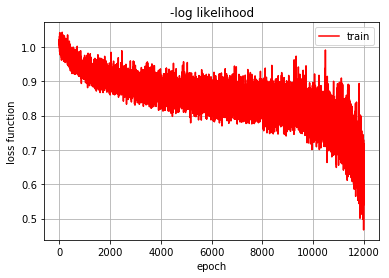

In [22]:
plt.plot(cost_train, 'r-', label='train')
# plt.plot(cost_test, 'g-', label='test')
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.title('-log likelihood')
plt.legend()
plt.grid()
plt.show()

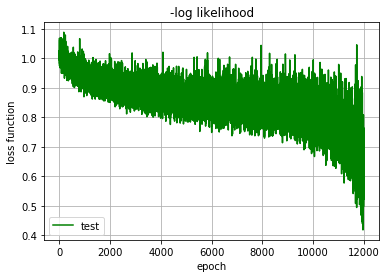

In [23]:
# plt.plot(cost_train, 'r-', label='train')
plt.plot(cost_test, 'g-', label='test')
plt.xlabel('epoch')
plt.ylabel('loss function')
plt.title('-log likelihood')
plt.legend()
plt.grid()
plt.show()

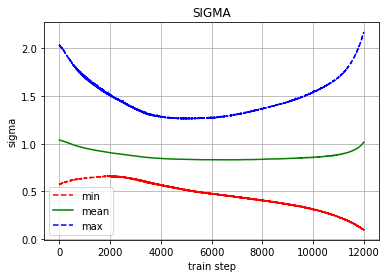

In [14]:
plt.plot(SIGMA['Smin'][:,0], 'r--', label='min')
plt.plot(SIGMA['Smean'][:,0], 'g-', label='mean')
plt.plot(SIGMA['Smax'][:,0], 'b--', label='max')
plt.xlabel('train step')
plt.ylabel('sigma')
plt.title('SIGMA')
plt.legend()
plt.grid()
plt.show()

In [15]:
def get_pi_idx(x, pdf, h, w, order):
    
    accumulate = 0
    P = pdf[order,:,h,w]

    for i in range(KMIX):
        
        accumulate += P[i]
        if (accumulate >= x):
            return i
    
    print('error with sampling ensemble')
    
    return -1

In [16]:
def generate_ensemble(out_pi, out_mu, out_sigma, occlud):
    
    generated_image = np.copy(occlud)
    
    for order in range(number_generate):

        mu, std, idx = 0, 0, 0
        result = np.random.rand(height_occlud * width)
        rn = np.random.rand(height_occlud * width)
    
        count = 0
        for h in range(height_occlud,height):
            for w in range(width):
                
                idx = get_pi_idx(result[count], out_pi, h, w, order)
                mu = out_mu[order,idx, h, w]
                std = out_sigma[order, idx, h, w]
                generated_image[order,h,w,:] = mu + rn[count] * std
                
                # truncated normal
#                 lower = 0
#                 upper = 1
#                 a, b = (lower - mu) / std, (upper - mu) / std
#                 generated_image[order,h,w,:] = truncnorm.pdf(rn[count], a, b, loc = mu, scale = std)
                # end of truncated normal
                
                count += 1
            
    return generated_image

In [17]:
# generate
number_generate = 5

test_data = mnist.train.next_batch(number_generate)
test_data = test_data[0]

original = test_data

occlud = np.copy(test_data)
occlud[:, height_occlud * width : height * width] = 0

original = original.reshape((number_generate,height,width,1))
occlud = occlud.reshape((number_generate,height,width,1))
oo = occlud.reshape((number_generate, height * width))
# occlud = occlud.reshape((number_generate, height, width, channel))
out_pi_occlud, out_sigma_occlud, out_mu_occlud,ss = sess.run(get_mixture_coef(conv_layer), feed_dict={X: oo})

out_pi_occlud = np.exp(out_pi_occlud)
out_sigma_occlud = np.exp(out_sigma_occlud)

y_occlud = generate_ensemble(out_pi_occlud, out_mu_occlud, out_sigma_occlud, occlud)

In [18]:
improve_generated_image = np.copy(y_occlud)

def improve(old_value, old_min, old_max, new_min, new_max):
#     new_value = ( (old_value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
    new_value = ( (old_value - old_min) / (old_max - old_min) )
    return new_value

for i in range(number_generate):
    
    half = improve_generated_image[i, height_occlud:height,0:width,0]
    old_min, old_max, new_min, new_max = np.min(half), np.max(half), 0, 1
    
    for h in range(height_occlud,height):
        for w in range(width):
            improve_generated_image[i,h,w,:] = improve(improve_generated_image[i,h,w,:],
                                                       old_min, old_max, new_min, new_max)

In [19]:
# show:

original_image = np.empty((height, width * number_generate))
occluded_image = np.empty((height, width * number_generate))
predicted_image = np.empty((height, width * number_generate))
improve_predicted_image = np.empty((height, width * number_generate))
            
for i in range(number_generate):
    original_image[0:height,i*width:(i+1)*width] = original[i].reshape([height,width])
    occluded_image[0:height,i*width:(i+1)*width] = occlud[i].reshape([height,width])
    predicted_image[0:height,i*width:(i+1)*width] = y_occlud[i].reshape([height,width])
    improve_predicted_image[0:height,i*width:(i+1)*width] = improve_generated_image[i].reshape([height,width])

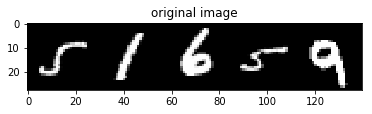

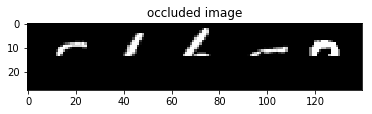

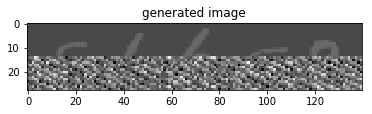

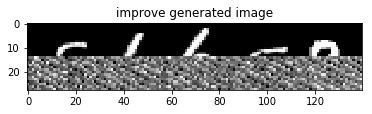

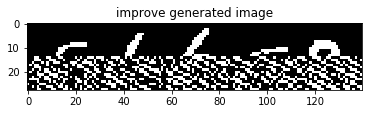

In [20]:
plt.imshow(original_image, cmap="gray")
plt.title("original image")
plt.show()

plt.imshow(occluded_image, cmap="gray")
plt.title("occluded image")
plt.show()

plt.imshow(predicted_image, cmap="gray")
plt.title("generated image")
plt.show()

plt.imshow(improve_predicted_image, cmap="gray")
plt.title("improve generated image")
plt.show()

plt.imshow(improve_predicted_image>0.5, cmap="gray")
plt.title("improve generated image")
plt.show()